Connected to rework (Python 3.10.14)

In [ ]:
import pandas as pd
import numpy as np
from ma_mapper import utility
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [ ]:
repeatmasker_filepath = '/rds/project/rds-XrHDlpCeVDg/users/pakkanan/data/resource/repeatmasker_table/hg38_repeatlib2014/hg38.fa.out.tsv'
combined_table_dir = '/rds/project/rds-XrHDlpCeVDg/users/pakkanan/data/output/teatime/combined_age_div_lenient'

In [ ]:
age_canon = utility.age_canon() #list of TEATIME age 
age_ref_table_template = utility.age_reference_table() #table for visualization component
age_ref_table = pd.DataFrame(data=age_ref_table_template).iloc[0:-1]
repeatmasker_table  = utility.repeatmasker_prep(repeatmasker_filepath) # repeatmasker
repeatmasker_table['rmsk_index'] = repeatmasker_table.index
if combined_table_dir is None:
    combined_table_dir = '/'.join(str.split(repeatmasker_filepath, sep ='/')[:-1])
combined_te_age_filepath = f'{combined_table_dir}/all_subfamilies.itd.txt'
combined_te_age_df = pd.read_csv(combined_te_age_filepath, sep='\t') #precomputed TEATIME age
repeatmasker_update=repeatmasker_table.merge(combined_te_age_df, how = 'left', on='rmsk_index') #combining two tables for information needed
age_df = repeatmasker_update[~repeatmasker_update['te_age'].isna()].copy() #filter out entries without TEATIME
##convert kimura distances into estimate age
age_df['div_percent'] = age_df['te_div']
age_df['div_fraction'] = age_df['div_percent']/100
age_df['div_age'] = age_df['div_fraction']/(2*2e-9)
age_df['div_age_mya'] = age_df['div_age']/1e+6
age_df['length'] =  age_df.genoEnd - age_df.genoStart
##binning kimuradistance 
bins = [-0.1]
genomesize = 3049315783
for i in range(0,62):
    bins.append(i+0.9)
age_df['binned'] = pd.cut(age_df['div_percent'], bins=bins, labels=list(range(0,62)))
#binning derived age by 1
bins = [-1]
for i in range(0,158):
    bins.append(i+0.9)
age_df['mya_binned'] = pd.cut(age_df['div_age_mya'], bins=bins, labels=list(range(0,158)))
#binning derived age by 10
bins = [-1]
for i in range(0,160,10):
    bins.append(i+9)
age_df['mya_10binned'] = pd.cut(age_df['div_age_mya'], bins=bins, labels=list(range(0,160,10)))
#add genome coverage
age_df['percent_coverage'] = age_df.length/genomesize*100
# Create a custom mapping for specific subclasses
comparable_cat = ['SINE/MIR','SINE/tRNA-Deu','SINE/tRNA-RTE','SINE/tRNA','SINE/Alu','SINE/5S-Deu-L2','Retroposon/SVA','LINE/Penelope','LINE/Dong-R4','LINE/Jockey','LINE/L2','LINE/CR1','LINE/RTE-X','LINE/RTE-BovB','LINE/L1','LINE/L1-Tx1', 'LTR/ERVK','LTR/ERV1','LTR','LTR/ERVL','LTR/ERVL-MaLR','LTR/Gypsy','RC/Helitron','DNA/TcMar','DNA/TcMar-Mariner','DNA/TcMar-Pogo','DNA/TcMar-Tc1','DNA/TcMar-Tc2','DNA/TcMar-Tigger','DNA/PiggyBac','DNA/MULE-MuDR','DNA/Merlin','DNA','DNA/Kolobok','DNA/hAT','DNA/hAT-Ac','DNA/hAT-Blackjack','DNA/hAT-Charlie','DNA/hAT-Tag1','DNA/hAT-Tip100','DNA/PIF-Harbinger','Unknown']
comparable_cat_color = ['#D7B4F8','#CE9BF7','#C481F5','#B966F4','#B358F3','#A637F1','#FF4D4D','#ACD8E5','#99B3D7','#8FA1CF','#625CB1','#483AA2','#38299A','#38299A','#00008B','#00008B','#90ED90','#73CD70','#65BD61','#57AE51','#57AE51','#489E42','#FF00FF','#FF936C','#FF936C','#FF936C','#FF936C','#FF936C','#FF936C','#FF865E','#FF7850','#FF7149','#FF6A42','#FF5A34','#FF512D','#FF512D','#FF512D','#FF512D','#FF512D','#FF512D','#FF4825','#999999']
comparable_cat.reverse()
comparable_cat_color.reverse()
custom_groups = {
    'SINE/Alu': 'SINE/Alu',
    'SINE/MIR': 'SINE/MIR',
    'Retroposon/SVA': 'Retroposon/SVA',
    'LINE/L1': 'LINE/L1',
    'LINE/L2': 'LINE/L2',
    'LINE/CR1': 'LINE/CR1',
    'LTR/ERV1': 'LTR/ERV1',
    'LTR/ERVL': 'LTR/ERVL',
    'LTR/ERVL-MaLR': 'LTR/ERVL',
    'RC/Helitron':'RC/Helitron',
    'DNA/TcMar':'DNA/TcMar',
    'DNA/TcMar-Mariner':'DNA/TcMar',
    'DNA/TcMar-Pogo':'DNA/TcMar',
    'DNA/TcMar-Tc1':'DNA/TcMar',
    'DNA/TcMar-Tc2':'DNA/TcMar',
    'DNA/TcMar-Tigger':'DNA/TcMar',
    'DNA/hAT': 'DNA/hAT',
    'DNA/hAT-Ac': 'DNA/hAT',
    'DNA/hAT-Blackjack': 'DNA/hAT',
    'DNA/hAT-Charlie': 'DNA/hAT',
    'DNA/hAT-Tag1': 'DNA/hAT',
    'DNA/hAT-Tip100': 'DNA/hAT',
    'Unknown': 'Unknown'
    # Add more mappings as needed
}
# Group other subclasses into their respective major class followed by "/others"
for subclass in comparable_cat:
    if subclass not in custom_groups:
        major_class = subclass.split('/')[0]
        custom_groups[subclass] = f'{major_class}/others'

# Apply the custom group to the repClass_ column
age_df['custom_group'] = age_df['repClass'].map(custom_groups).fillna(age_df['repClass'])

In [ ]:
#summarize the table by age/and 10bin
age_count_overall = age_df.groupby(['te_age', 'mya_10binned']).count().reset_index()[['te_age','mya_10binned','genoName']].rename(columns={'genoName':'count'})

In [ ]:
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())
y_labels = sorted(age_count_overall["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

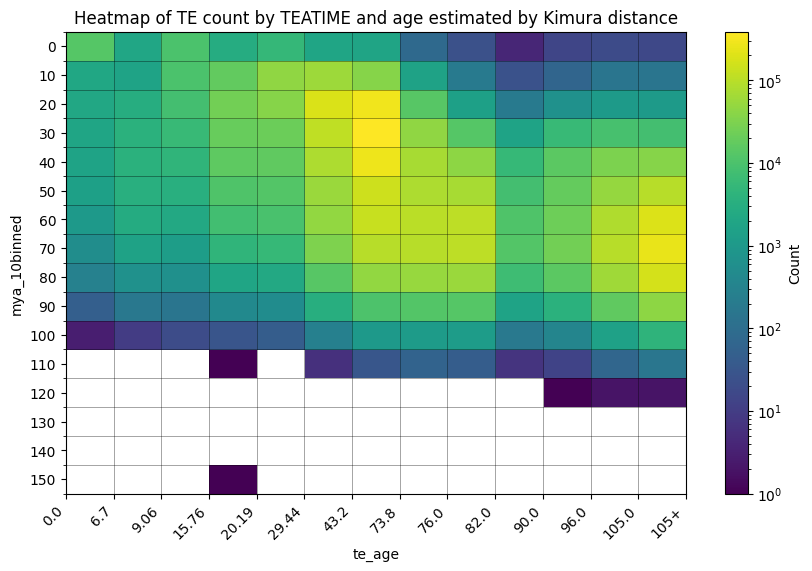

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
# Add '105+' as the last label
x_tick_labels = x_labels + ["105+"]

# Adjust x-tick positions to match **edges**, not centers
x_tick_positions = np.arange(len(x_labels) + 1) - 0.5  # Shift left to align with edges

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))
# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(heatmap_array, cmap="viridis", norm=norm, aspect="auto")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")


# Set axis labels
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=45, ha="right")  # Align labels properly
ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels)

ax.set_xlabel("te_age")
ax.set_ylabel("mya_10binned")
ax.set_title("Heatmap of TE count by TEATIME and age estimated by Kimura distance")

# ✅ FIX: Manually draw vertical gridlines at x-tick positions
for x in x_tick_positions:
    ax.axvline(x, color="black", linestyle="-", linewidth=0.5, alpha=0.5)
ax.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
ax.grid(True, which="minor", linestyle="-", color="black", linewidth=0.5, alpha=0.5)

plt.show()

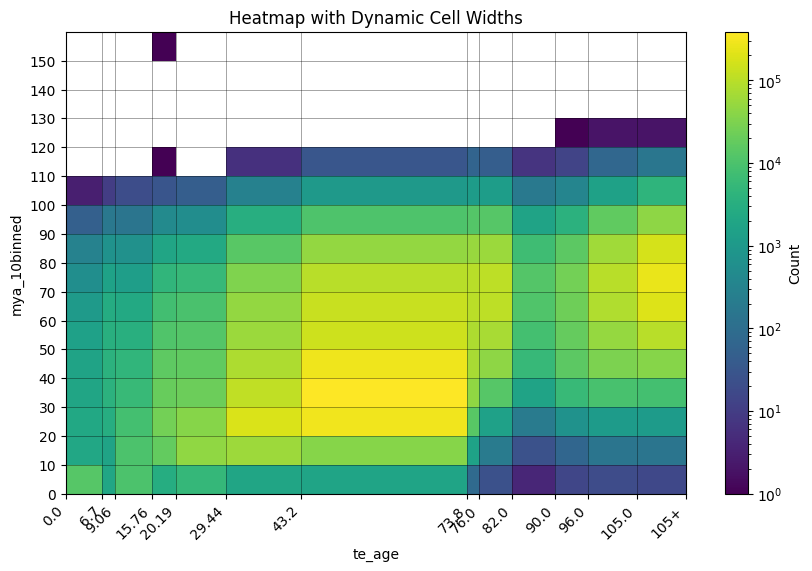

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("te_age")
ax.set_ylabel("mya_10binned")
ax.set_title("Heatmap with Dynamic Cell Widths")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

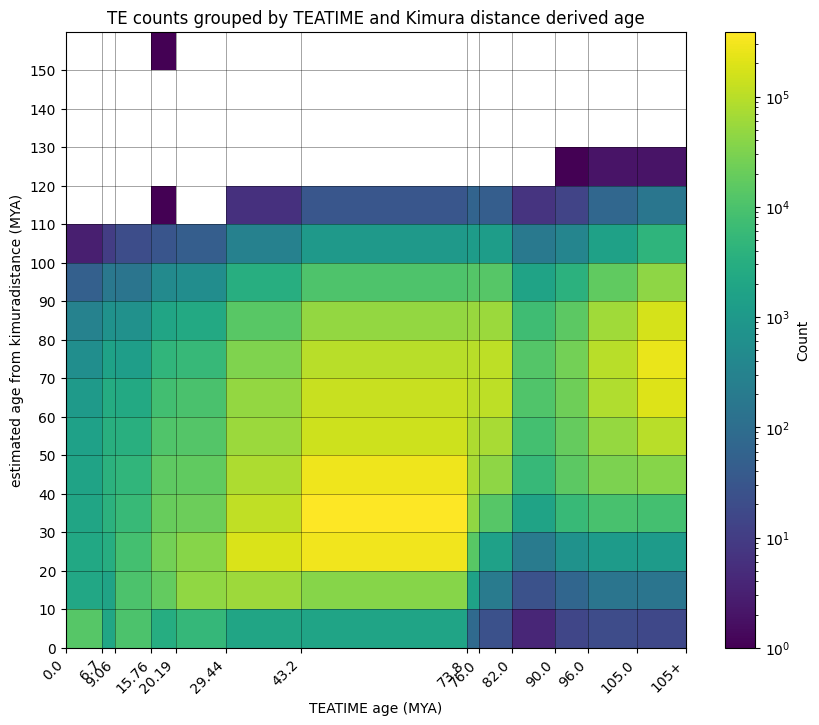

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

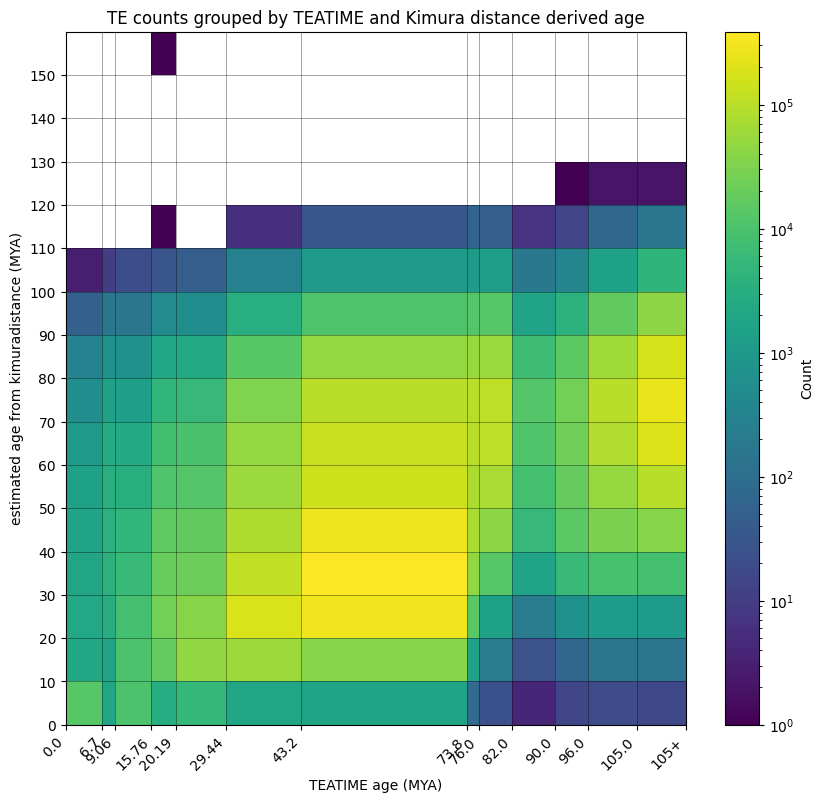

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(10, 9))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

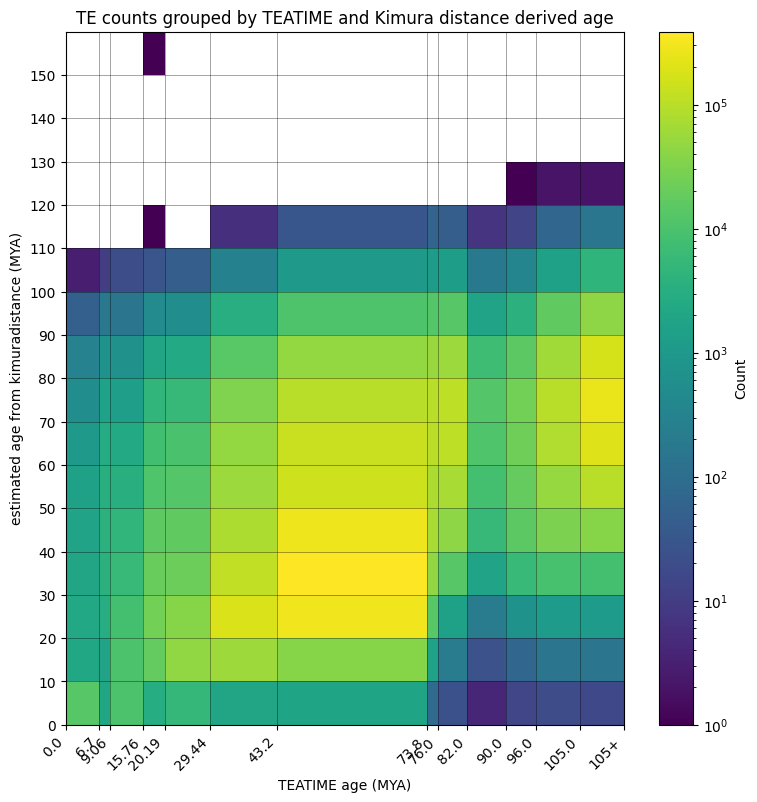

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(9, 9))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

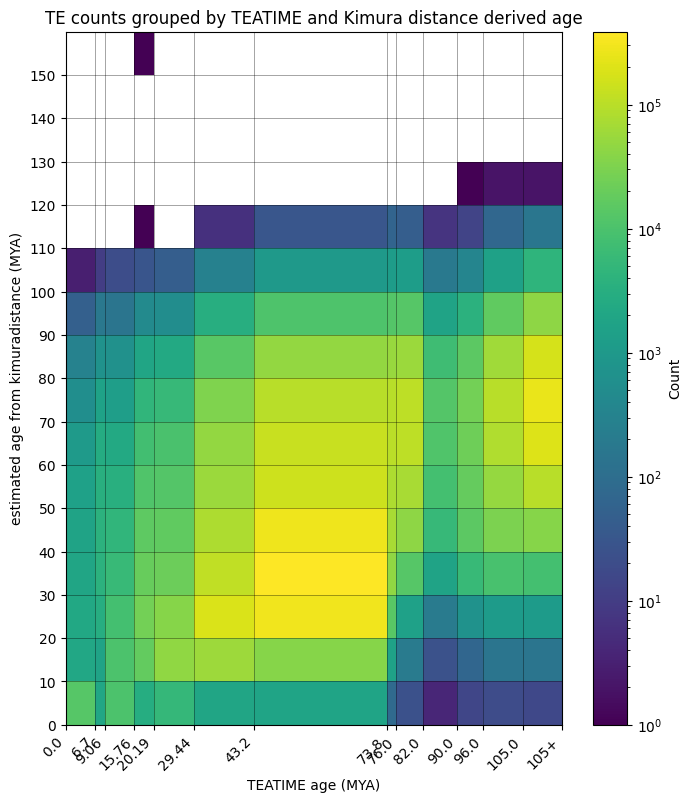

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 9))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

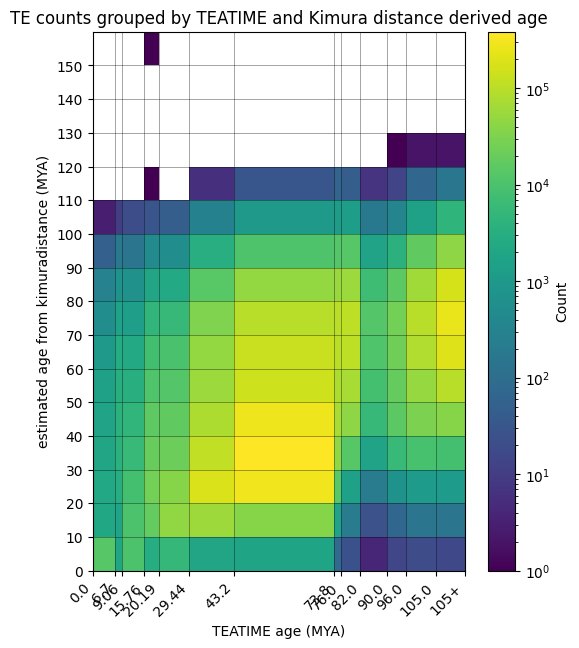

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(6, 7))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

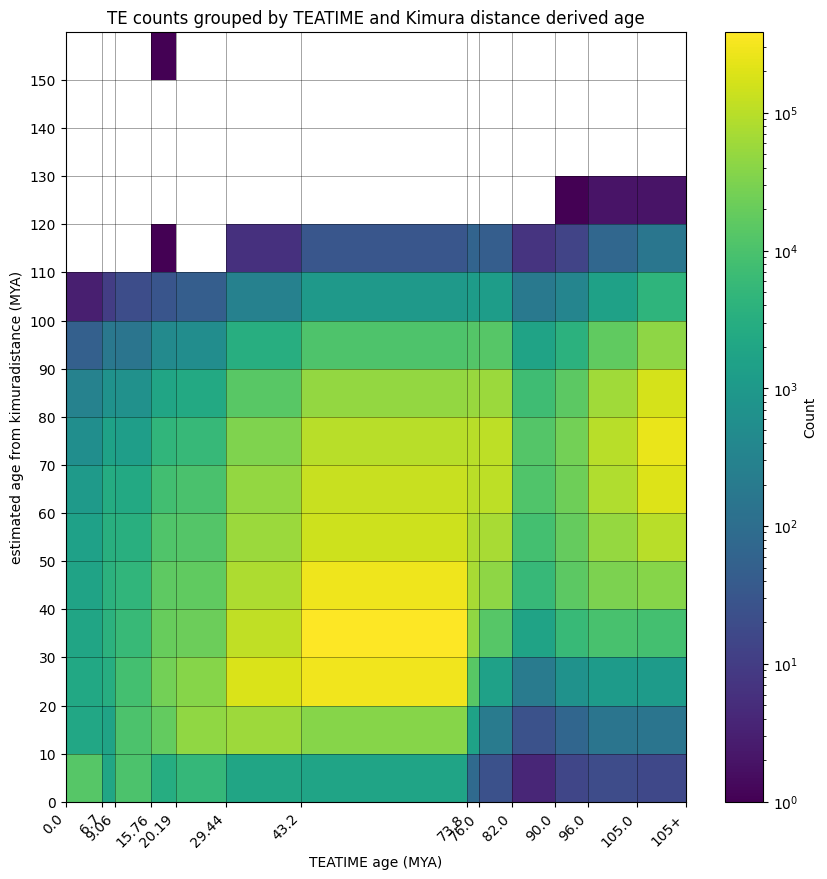

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

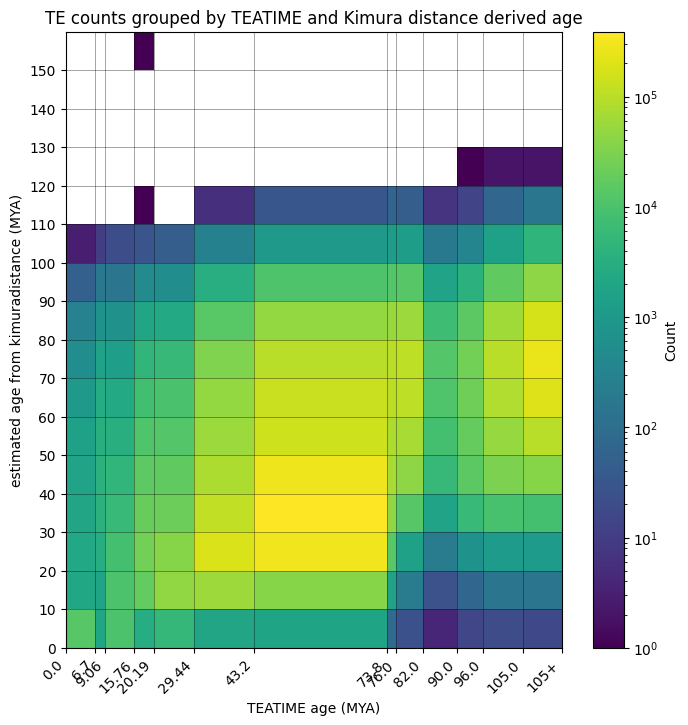

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

In [ ]:
age_count_byclass = age_df.groupby(['te_age', 'mya_10binned','custom_group']).count().reset_index()[['te_age','mya_10binned','custom_group','genoName']].rename(columns={'genoName':'count'})

In [ ]:
age_count_byclass

te_age mya_10binned     custom_group  count
0        0.0            0        DNA/TcMar      6
1        0.0            0       DNA/TcMar?      0
2        0.0            0          DNA/hAT      1
3        0.0            0  DNA/hAT-Tip100?      0
4        0.0            0       DNA/others      0
...      ...          ...              ...    ...
3947   105.0          150   Retroposon/SVA      0
3948   105.0          150         SINE/Alu      0
3949   105.0          150         SINE/MIR      0
3950   105.0          150      SINE/others      0
3951   105.0          150          Unknown      0

[3952 rows x 4 columns]

In [ ]:
#select specific class
class_of_interest = 'SINE/Alu'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

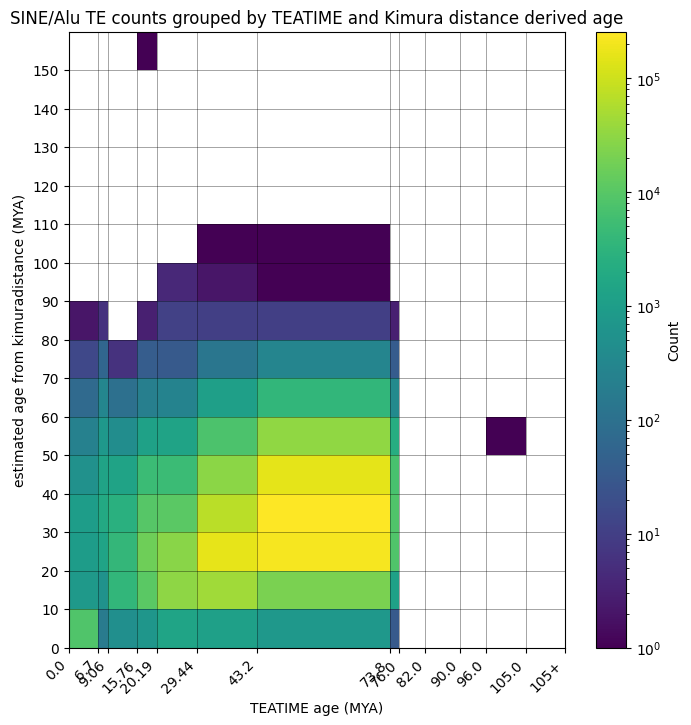

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

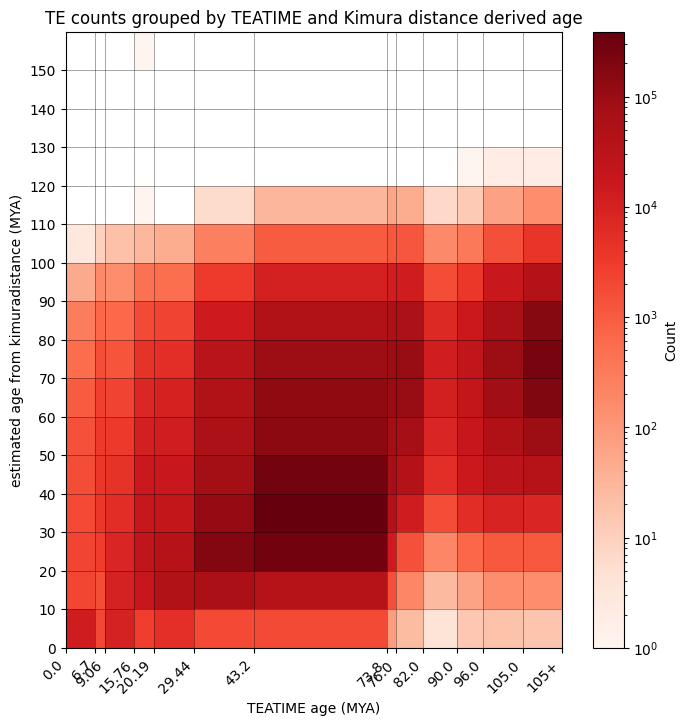

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="Reds", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

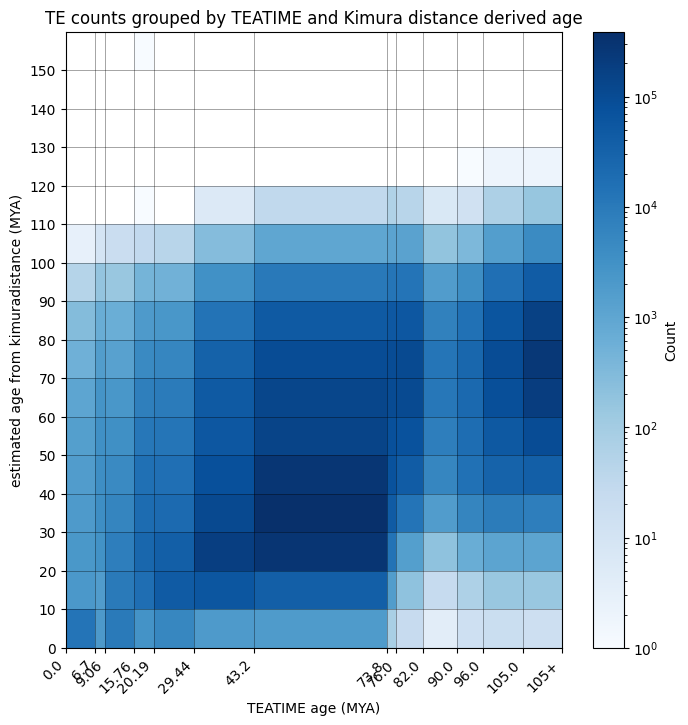

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="Blues", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

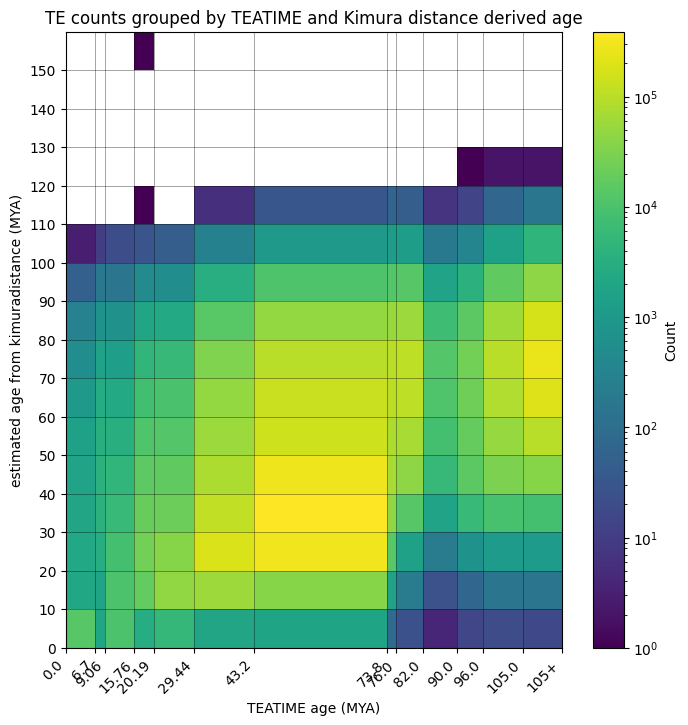

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

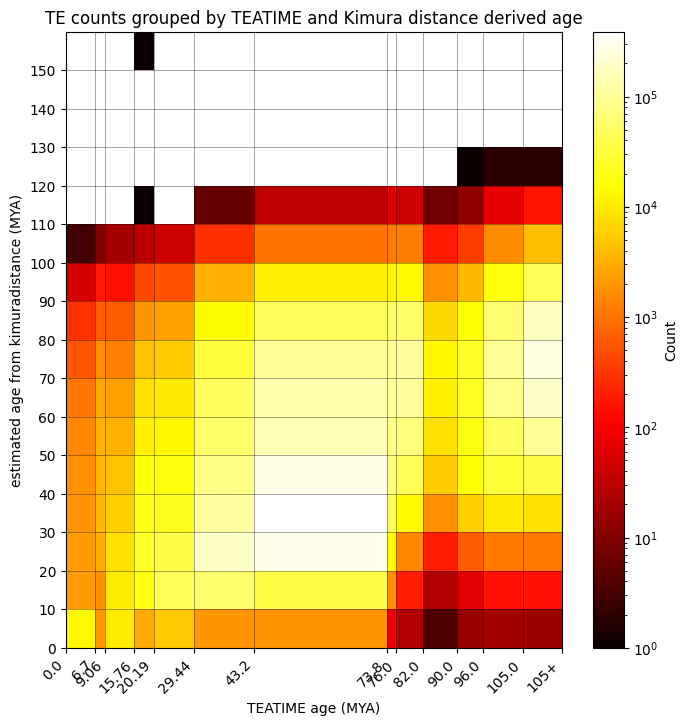

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

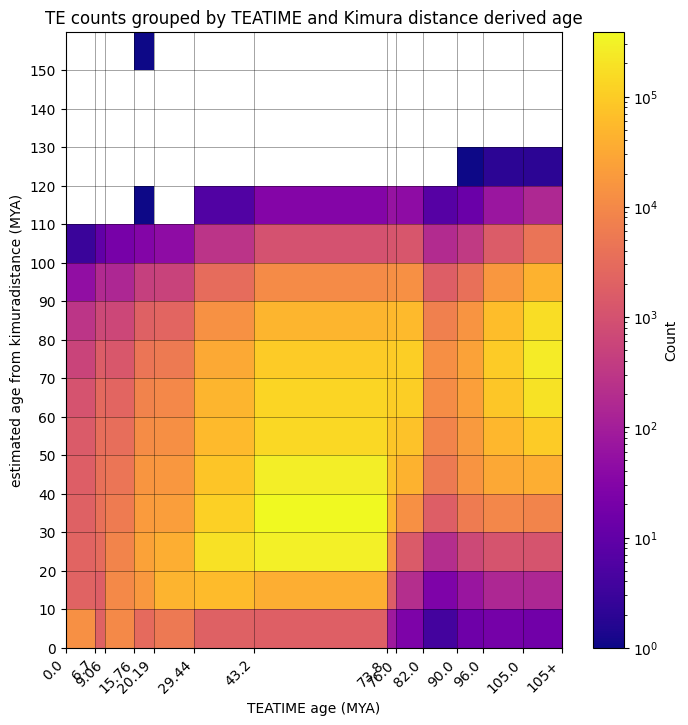

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="plasma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

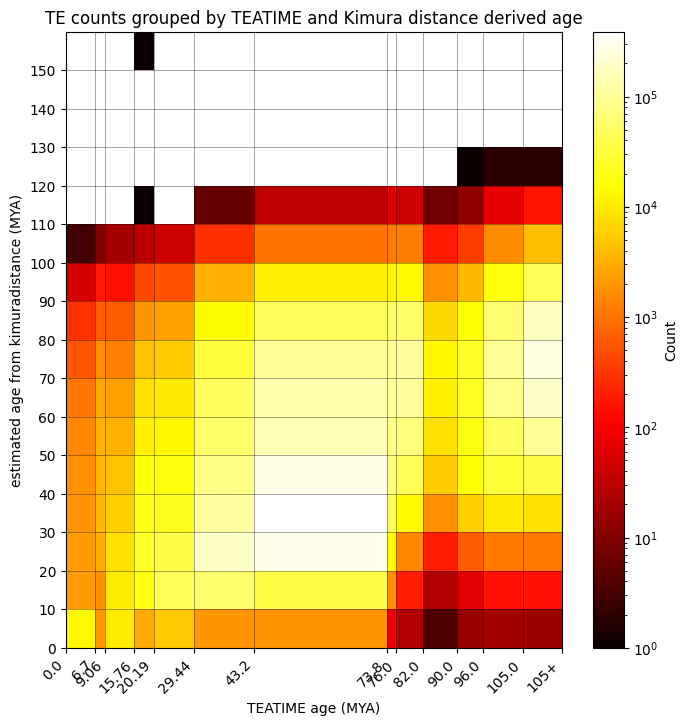

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

In [ ]:
#select specific class
class_of_interest = 'SINE/Alu'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

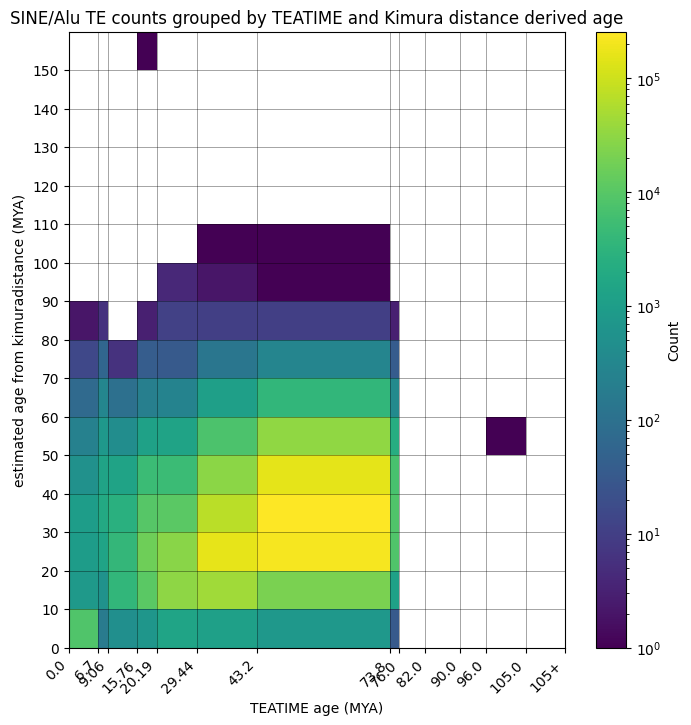

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="viridis", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

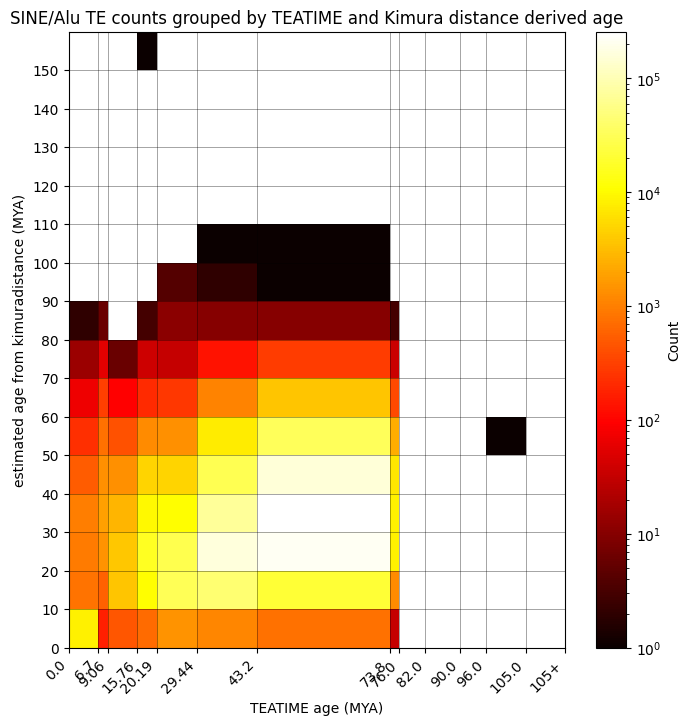

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

In [ ]:
#select specific class
class_of_interest = 'SINE/MIR'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

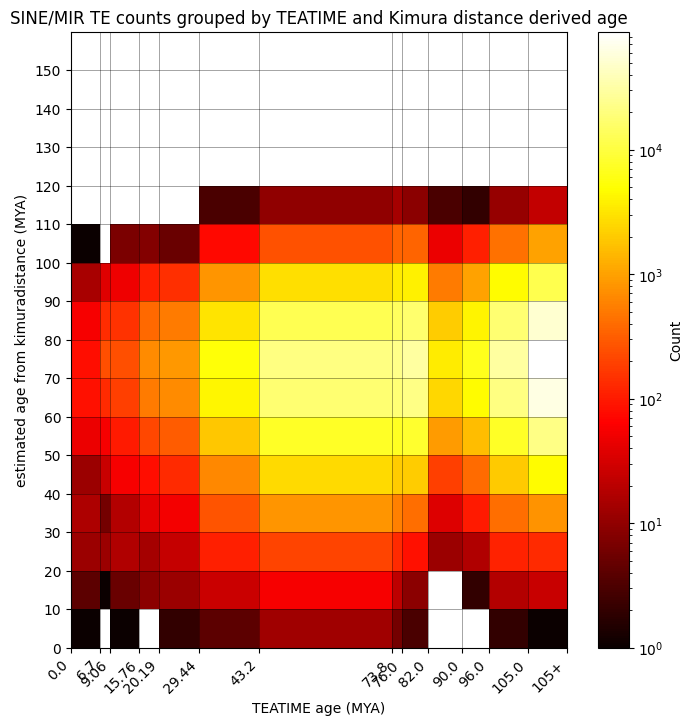

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

In [ ]:
#select specific class
class_of_interest = 'SINE/Others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

IndexError: list index out of range

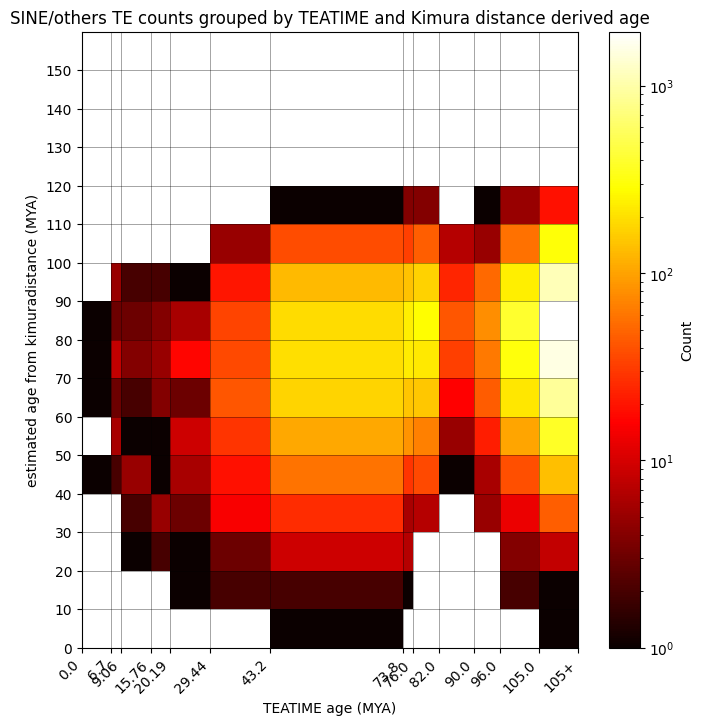

In [ ]:
#select specific class
class_of_interest = 'SINE/others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

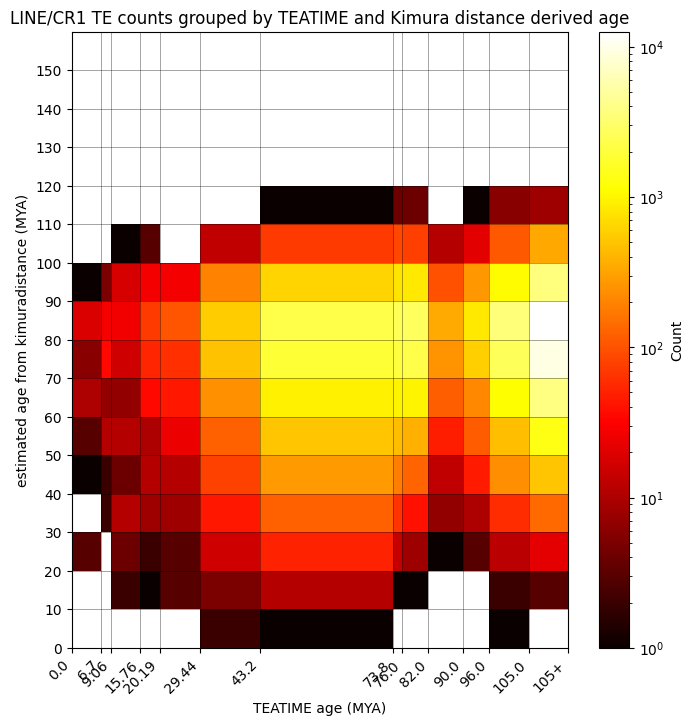

In [ ]:
#select specific class
class_of_interest = 'LINE/CR1'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

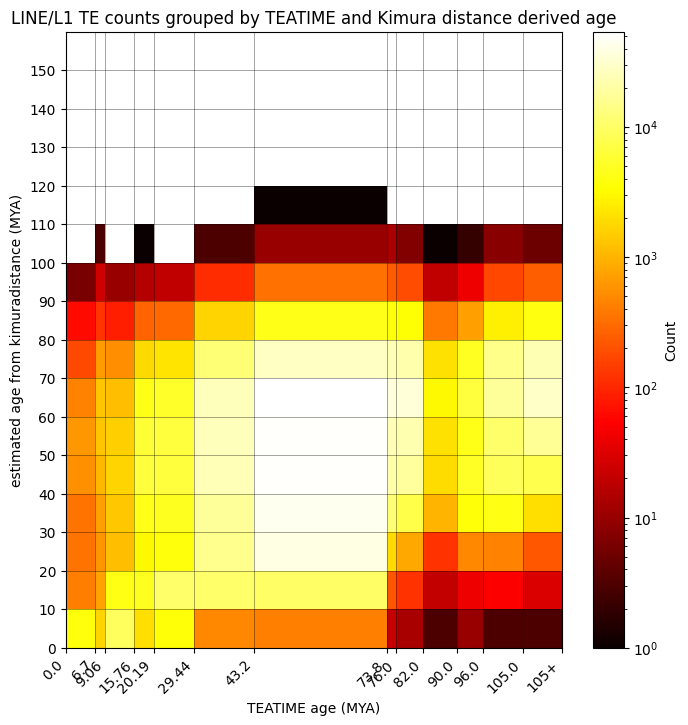

In [ ]:
#select specific class
class_of_interest = 'LINE/L1'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

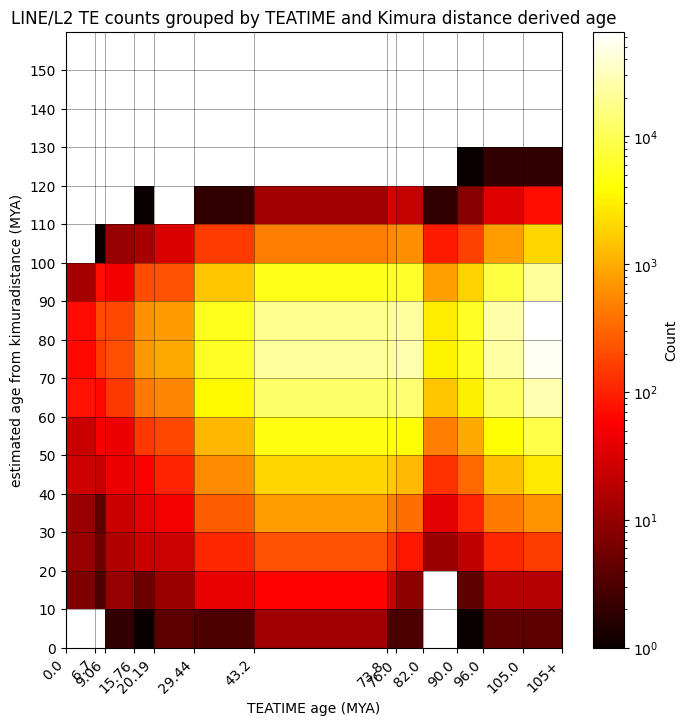

In [ ]:
#select specific class
class_of_interest = 'LINE/L2'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

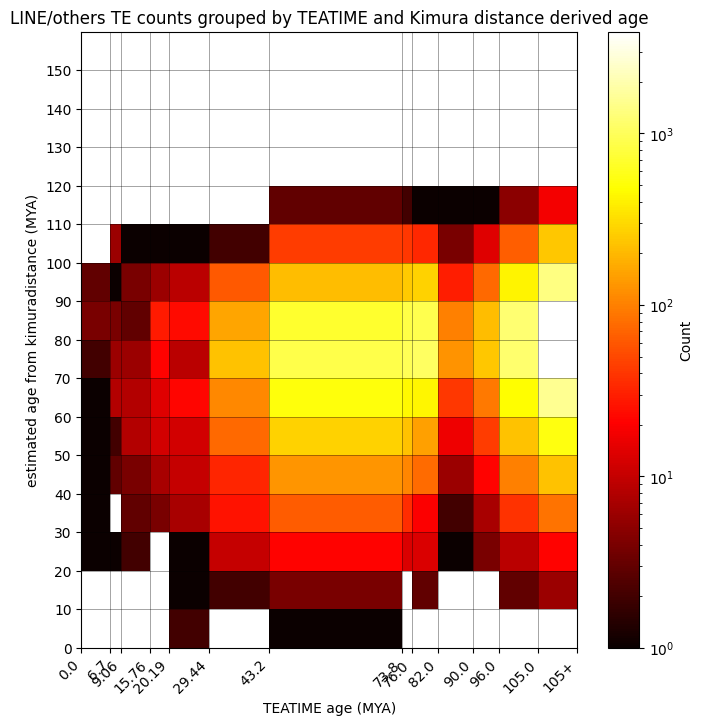

In [ ]:
#select specific class
class_of_interest = 'LINE/others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

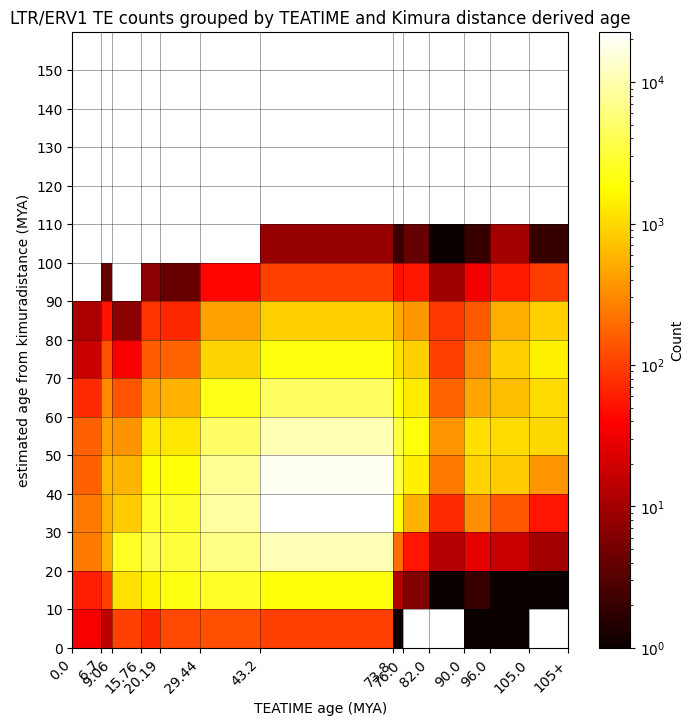

In [ ]:
#select specific class
class_of_interest = 'LTR/ERV1'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

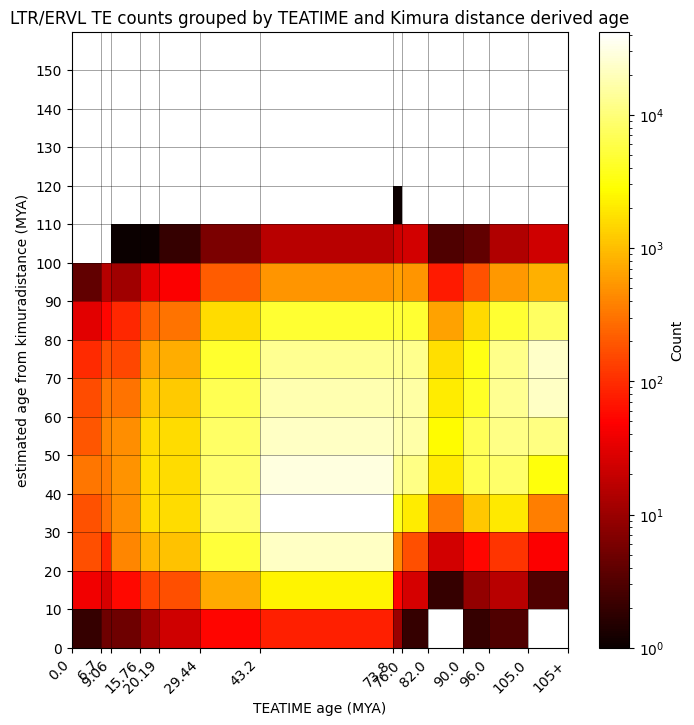

In [ ]:
#select specific class
class_of_interest = 'LTR/ERVL'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

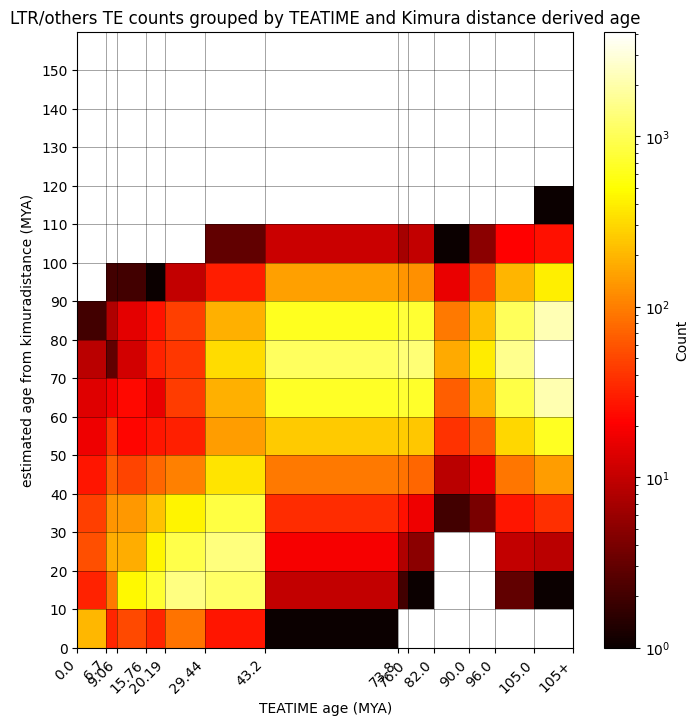

In [ ]:
#select specific class
class_of_interest = 'LTR/others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

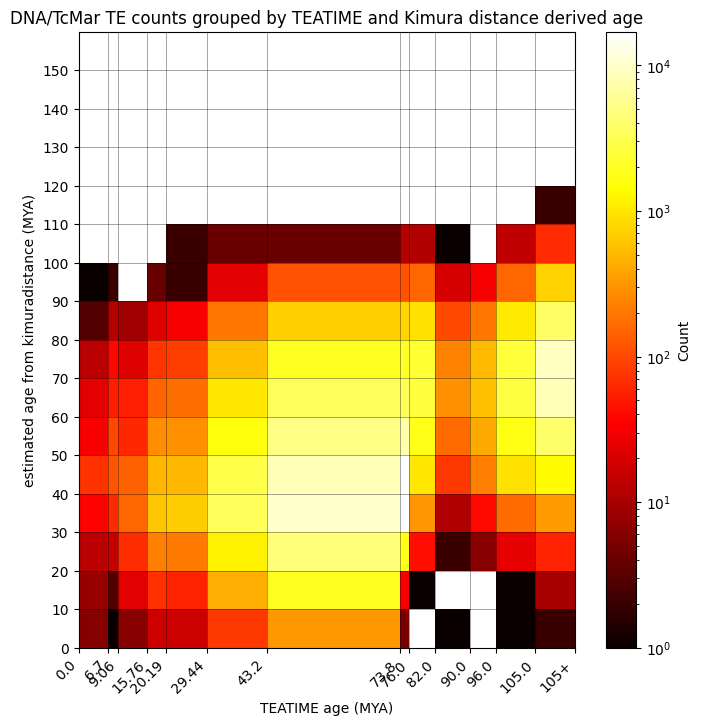

In [ ]:
#select specific class
class_of_interest = 'DNA/TcMar'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

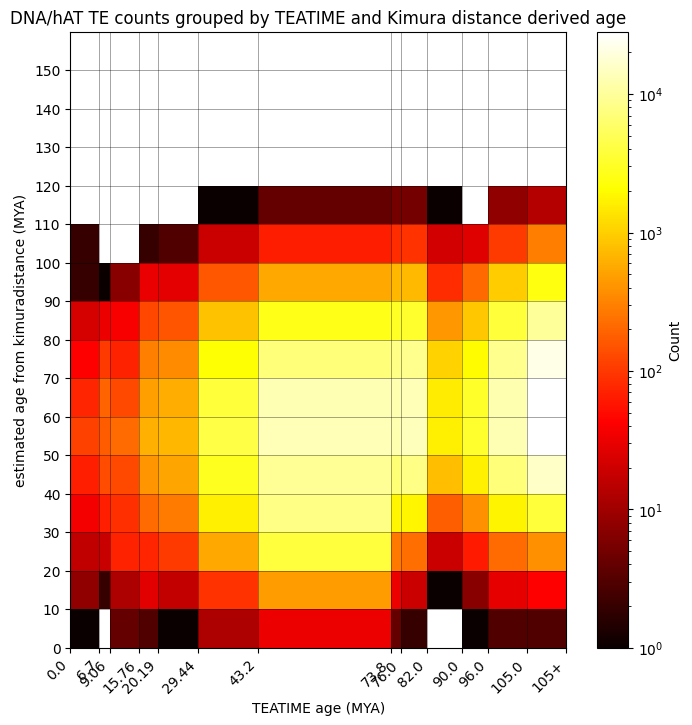

In [ ]:
#select specific class
class_of_interest = 'DNA/hAT'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

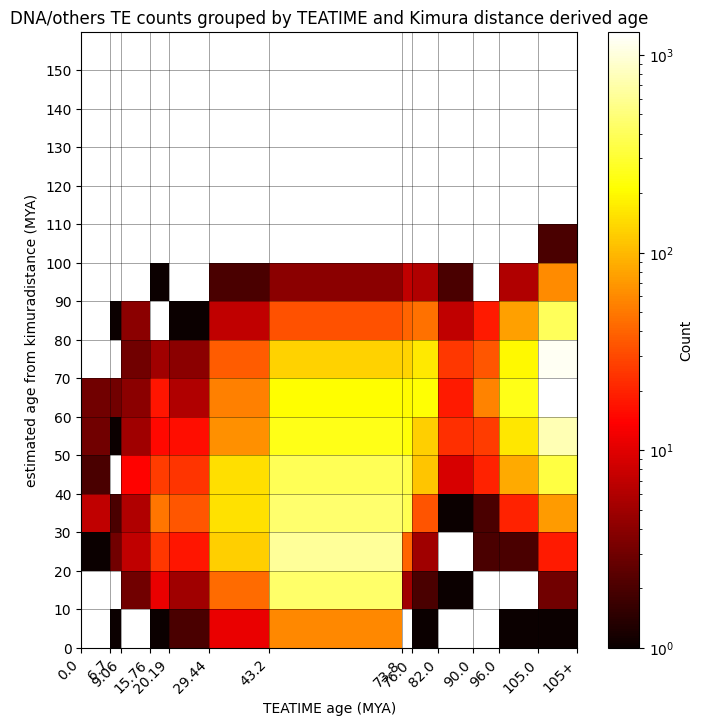

In [ ]:
#select specific class
class_of_interest = 'DNA/others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

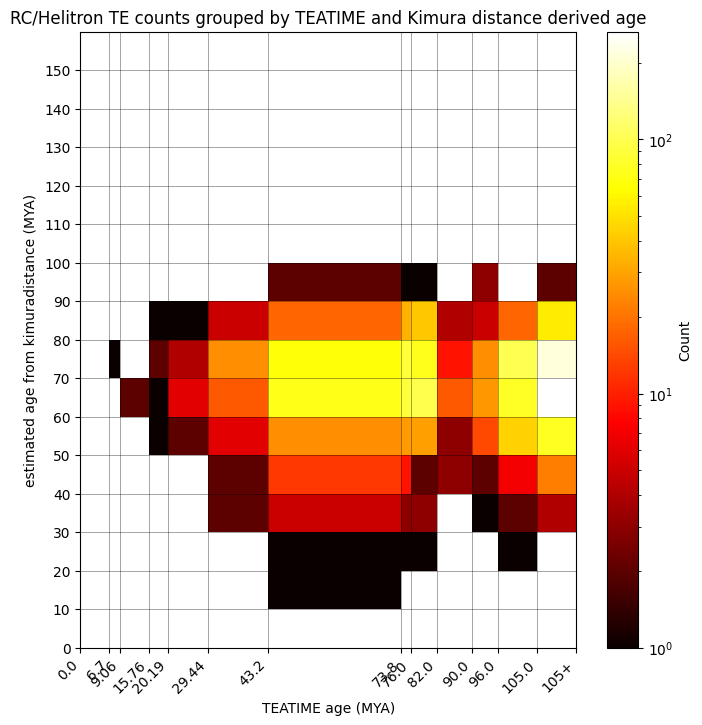

In [ ]:
#select specific class
class_of_interest = 'RC/Helitron'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

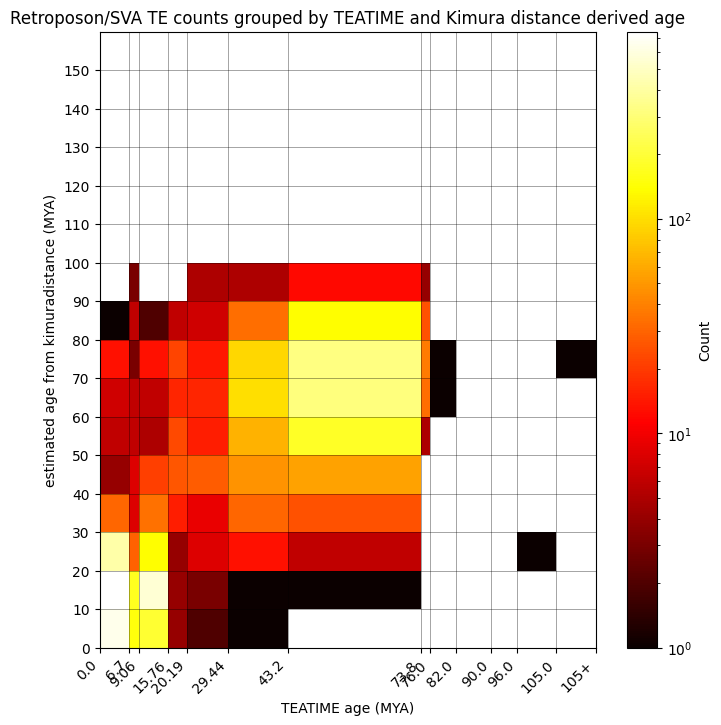

In [ ]:
#select specific class
class_of_interest = 'Retroposon/SVA'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

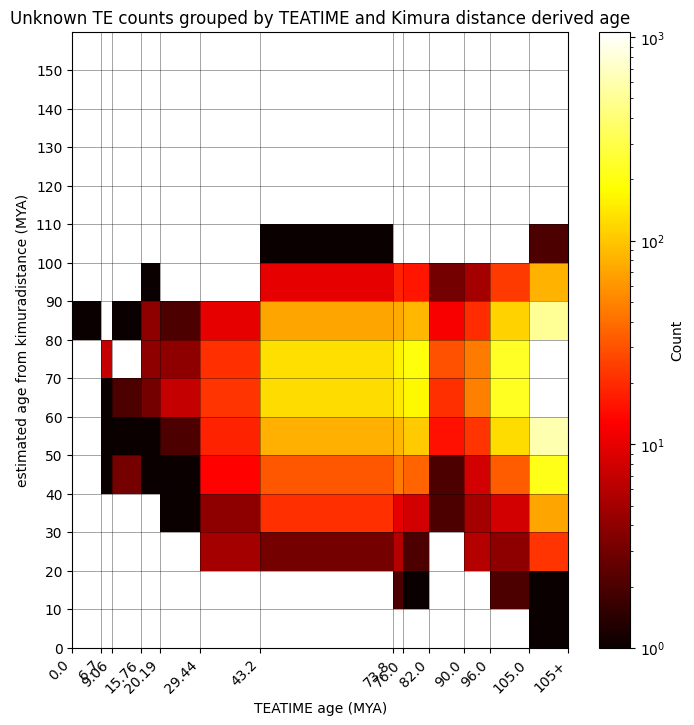

In [ ]:
#select specific class
class_of_interest = 'Unknown'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

In [ ]:
#select specific class
class_of_interest = 'L1HS'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

NameError: name 'age_count_bysubfam' is not defined

In [ ]:
#summarize the table by age/and 10bin and repname
age_count_bysubfam = age_df.groupby(['te_age', 'mya_10binned','repName']).count().reset_index()[['te_age','mya_10binned','repName','genoName']].rename(columns={'genoName':'count'})

In [ ]:
#select specific class
class_of_interest = 'L1HS'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

KeyError: 'custom_group'

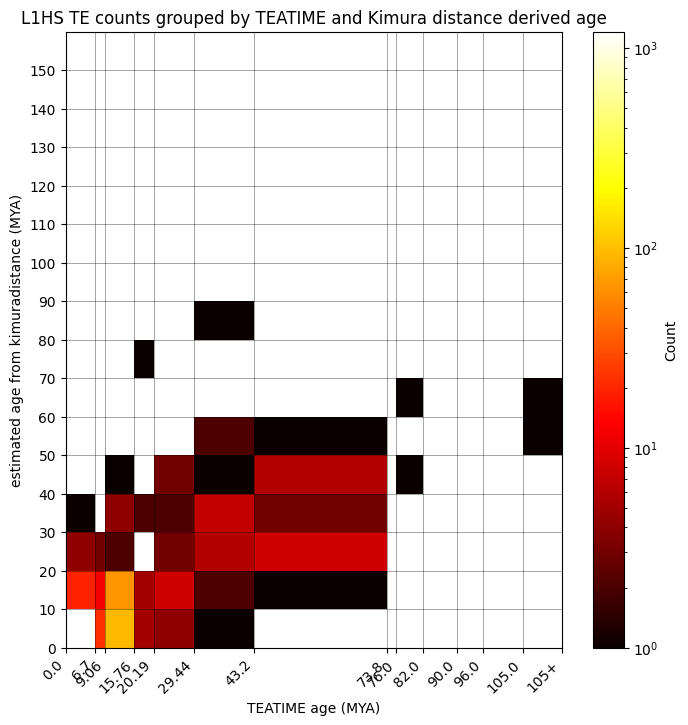

In [ ]:
#select specific class
subfam_of_interest = 'L1HS'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

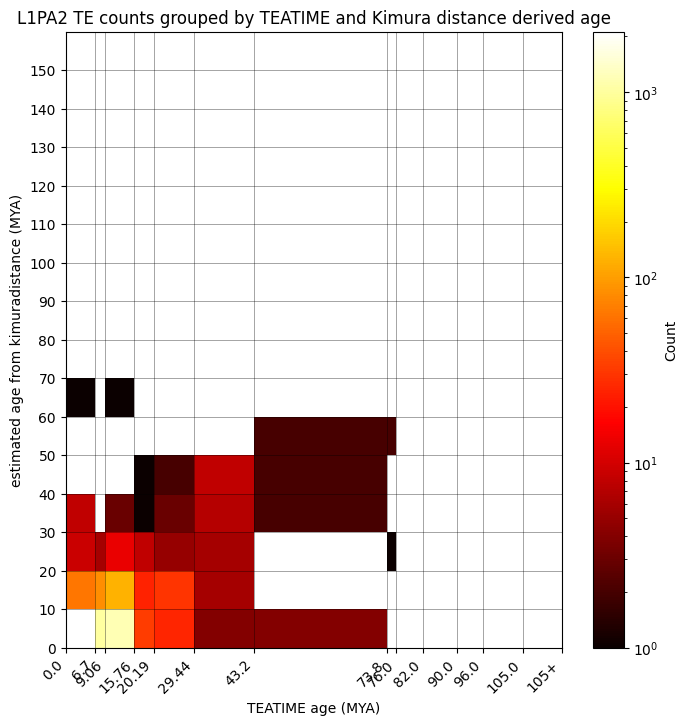

In [ ]:
#select specific class
subfam_of_interest = 'L1PA2'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

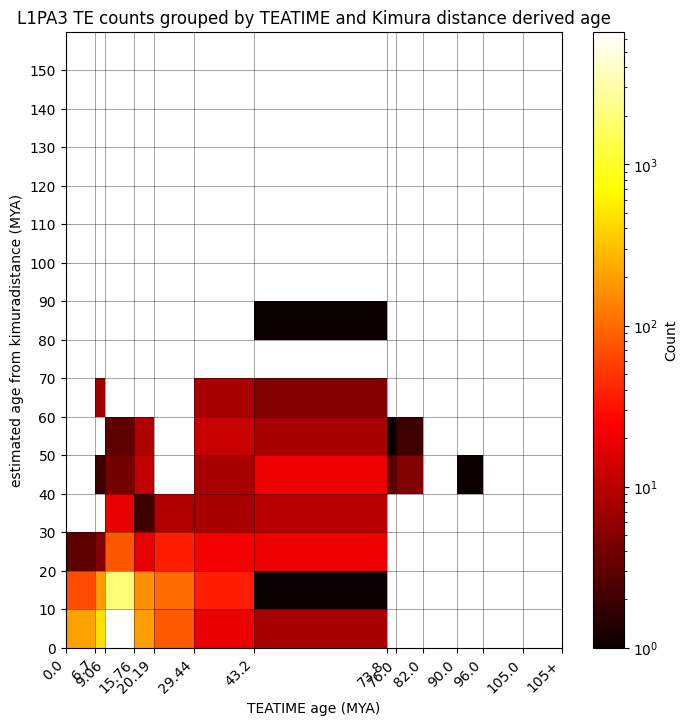

In [ ]:
#select specific class
subfam_of_interest = 'L1PA3'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

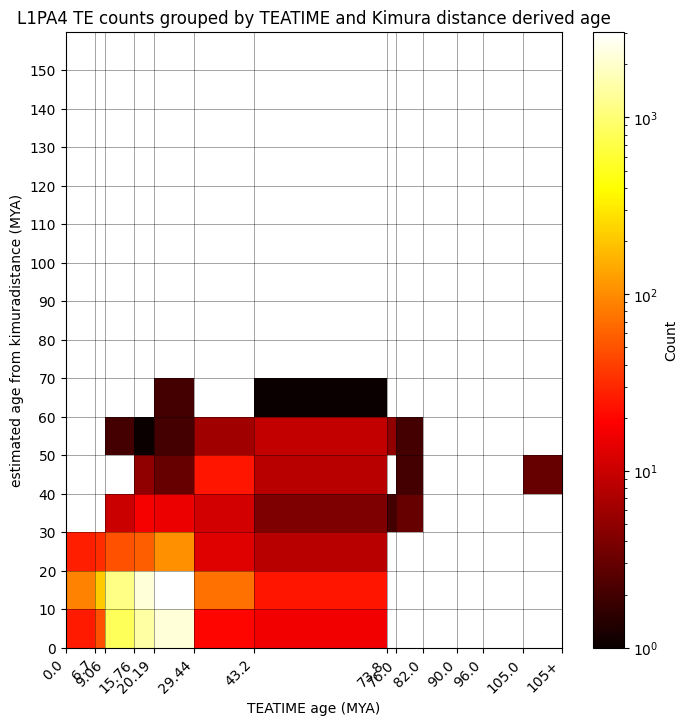

In [ ]:
#select specific class
subfam_of_interest = 'L1PA4'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

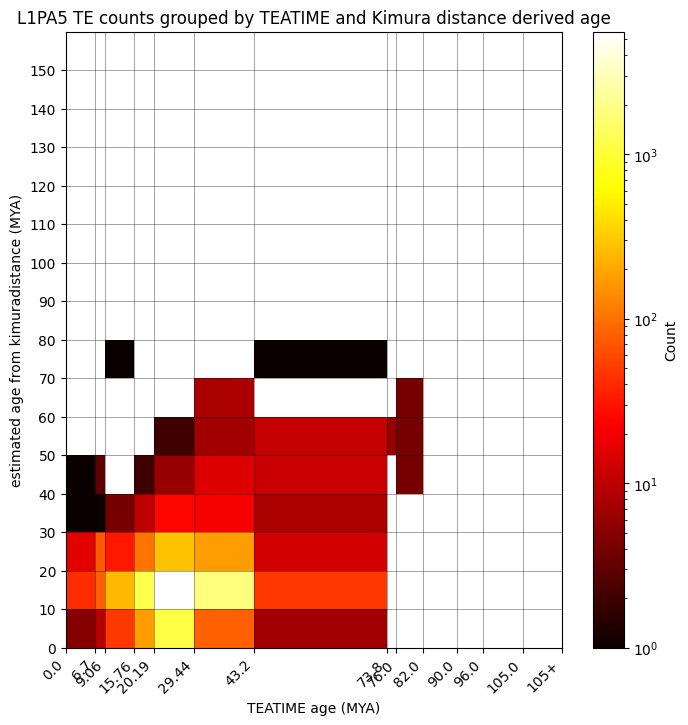

In [ ]:
#select specific class
subfam_of_interest = 'L1PA5'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

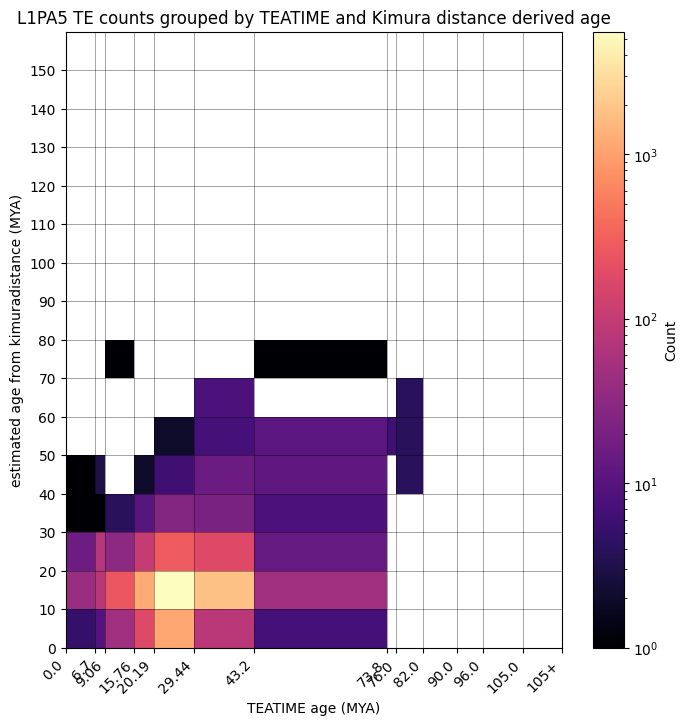

In [ ]:
#select specific class
subfam_of_interest = 'L1PA5'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

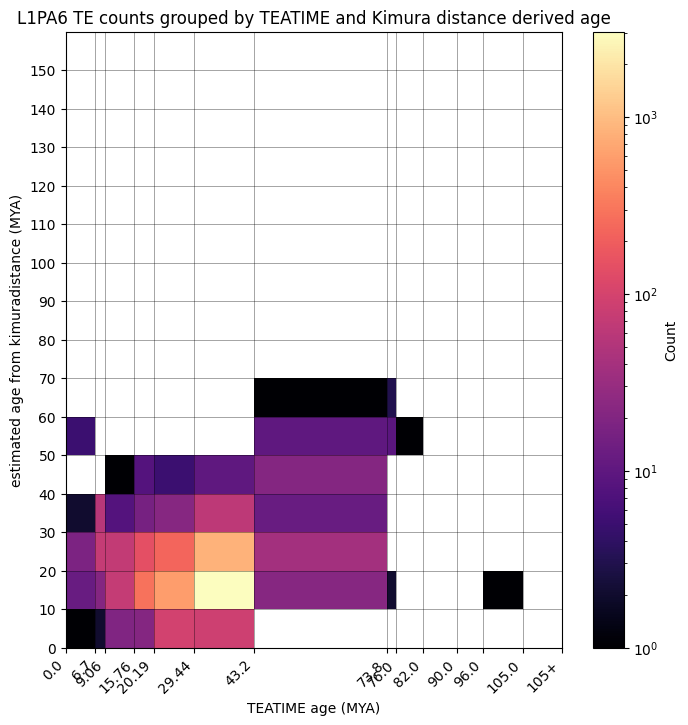

In [ ]:
#select specific class
subfam_of_interest = 'L1PA6'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

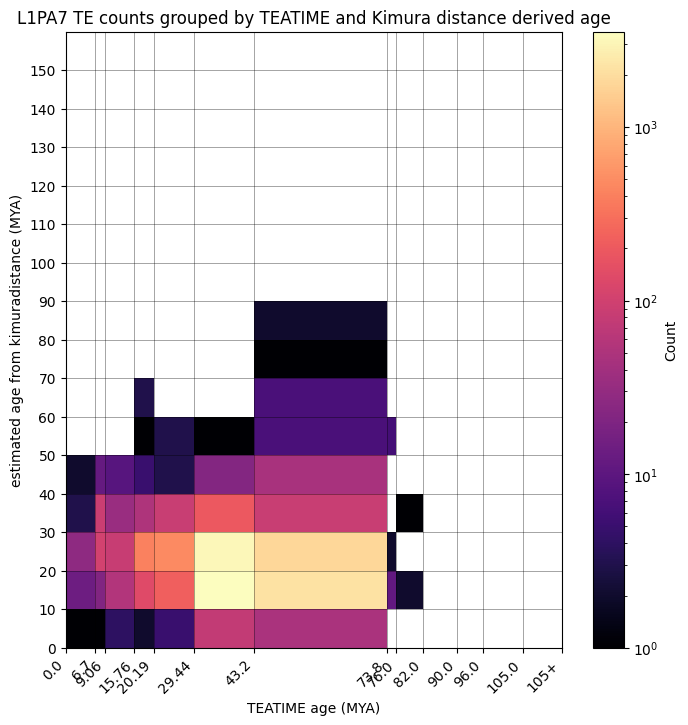

In [ ]:
#select specific class
subfam_of_interest = 'L1PA7'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

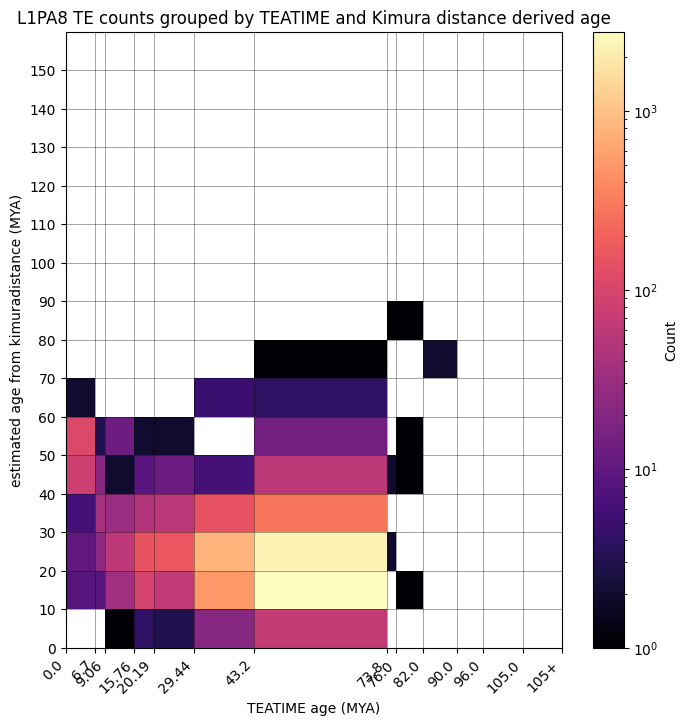

In [ ]:
#select specific class
subfam_of_interest = 'L1PA8'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

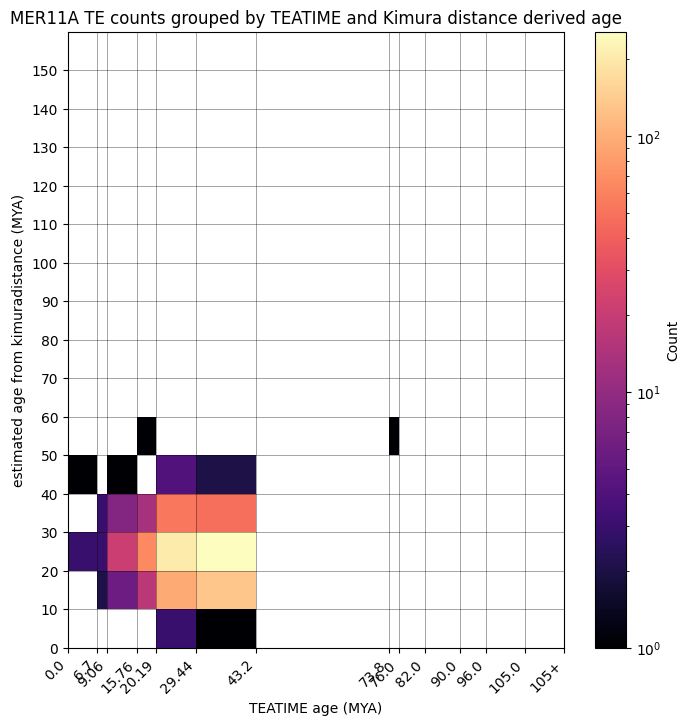

In [ ]:
#select specific class
subfam_of_interest = 'MER11A'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

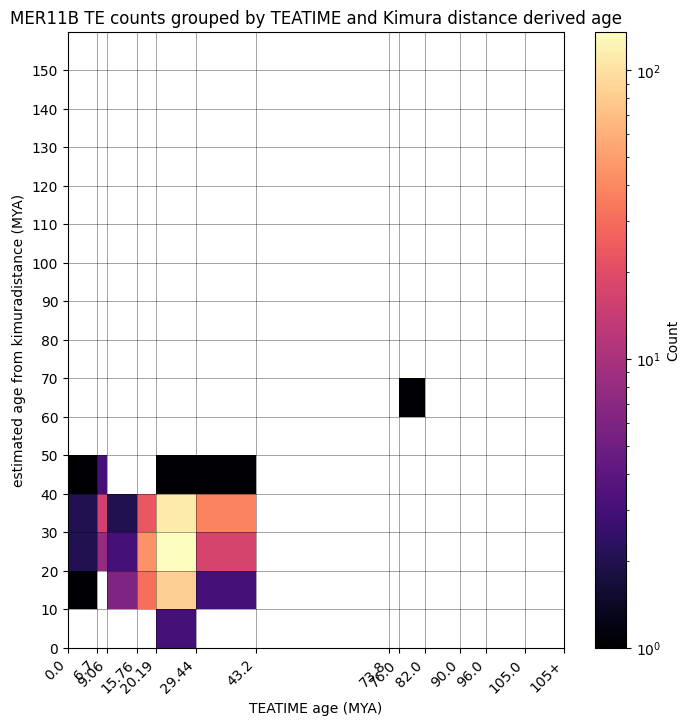

In [ ]:
#select specific class
subfam_of_interest = 'MER11B'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

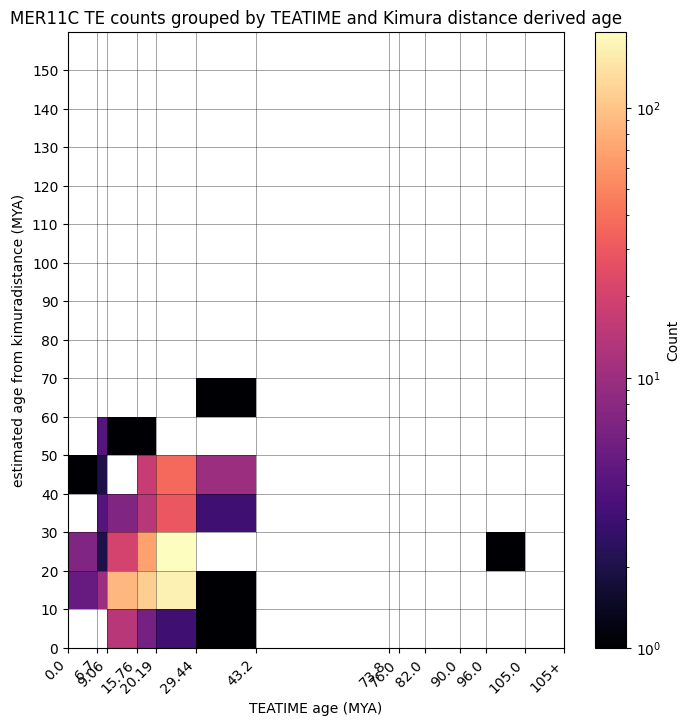

In [ ]:
#select specific class
subfam_of_interest = 'MER11C'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

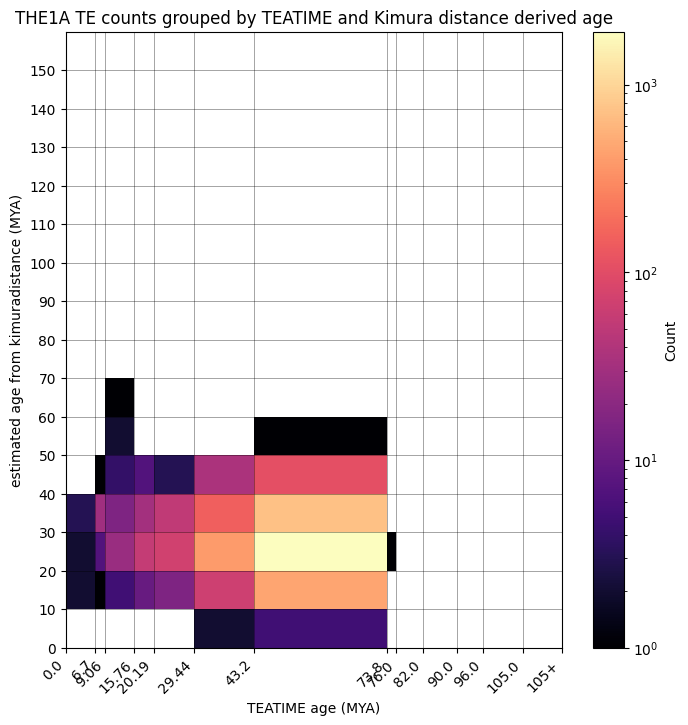

In [ ]:
#select specific class
subfam_of_interest = 'THE1A'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

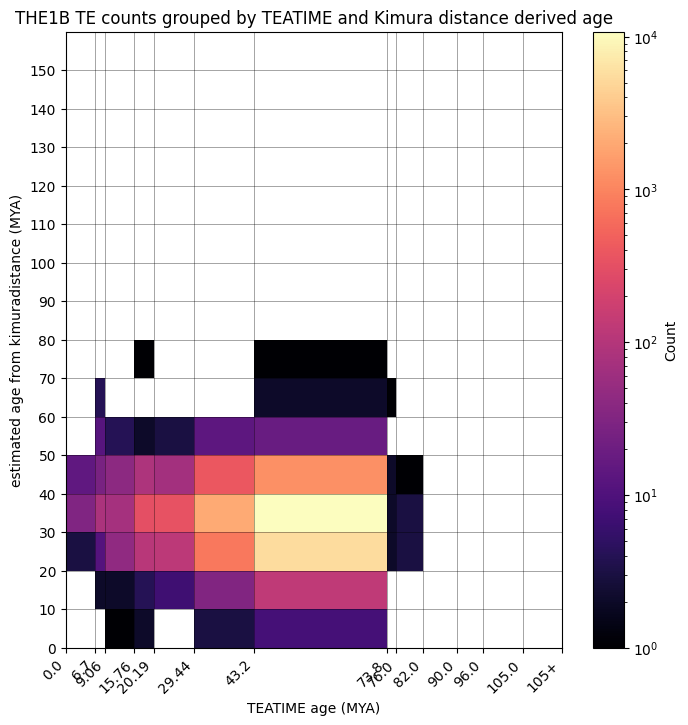

In [ ]:
#select specific class
subfam_of_interest = 'THE1B'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

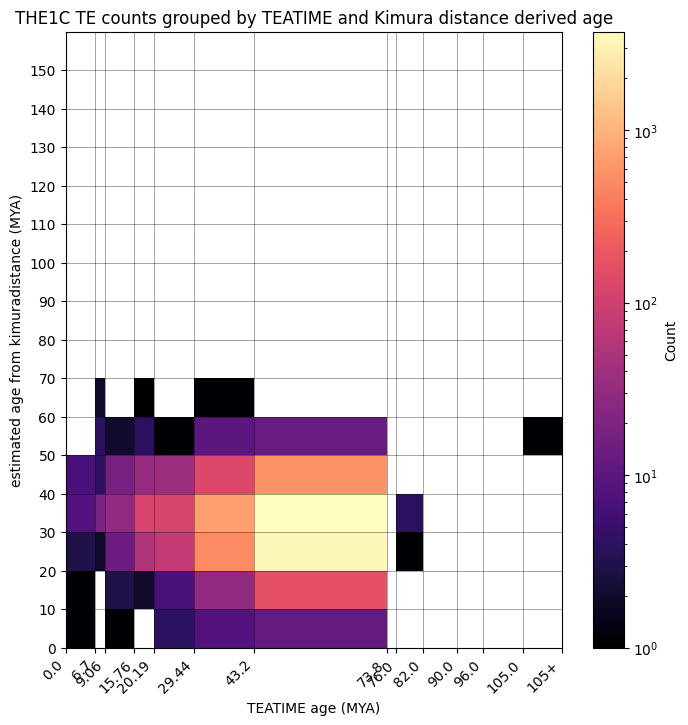

In [ ]:
#select specific class
subfam_of_interest = 'THE1C'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

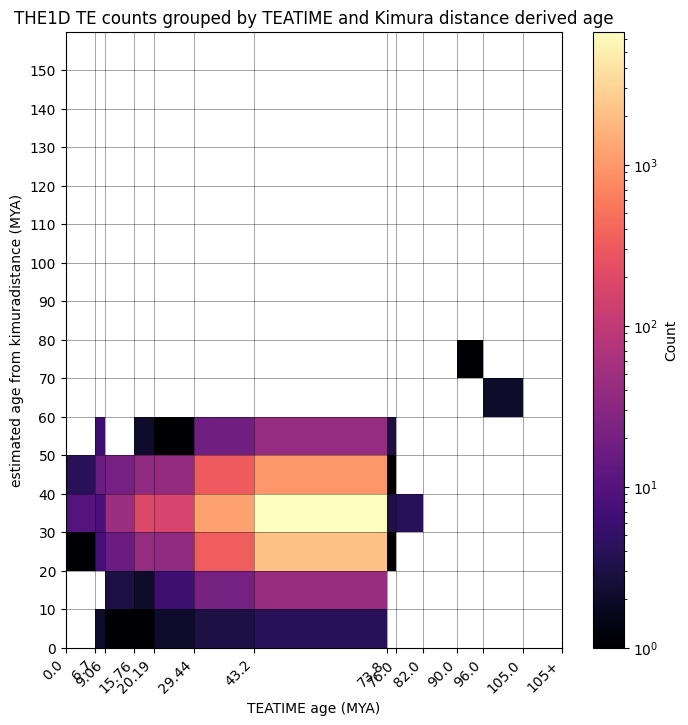

In [ ]:
#select specific class
subfam_of_interest = 'THE1D'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

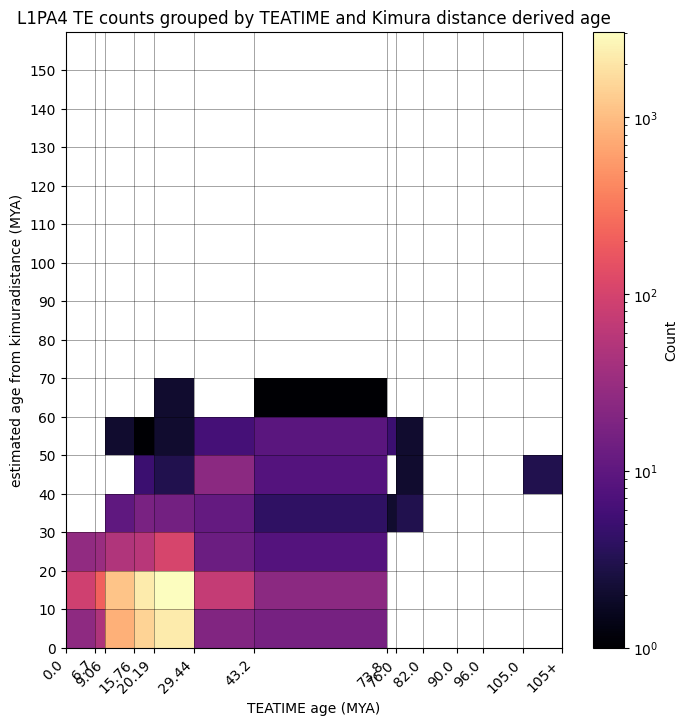

In [ ]:
#select specific class
subfam_of_interest = 'L1PA4'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

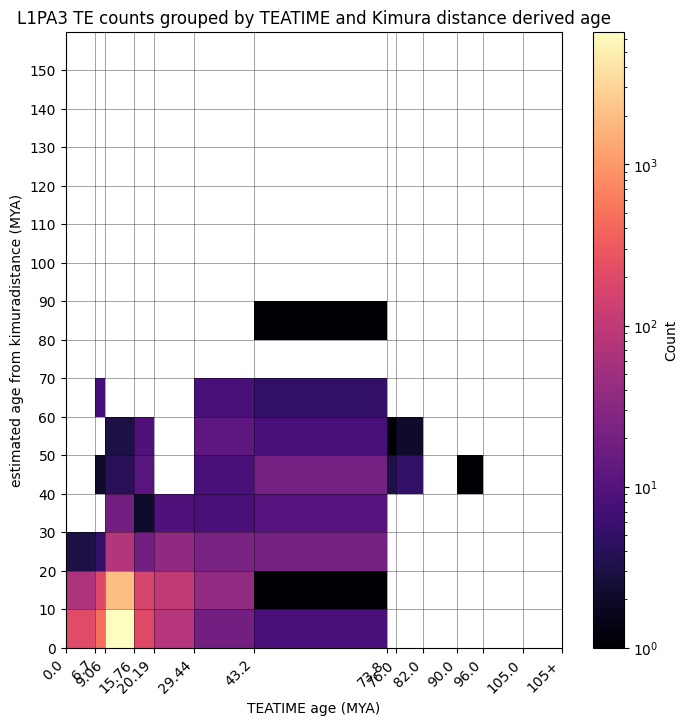

In [ ]:
#select specific class
subfam_of_interest = 'L1PA3'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

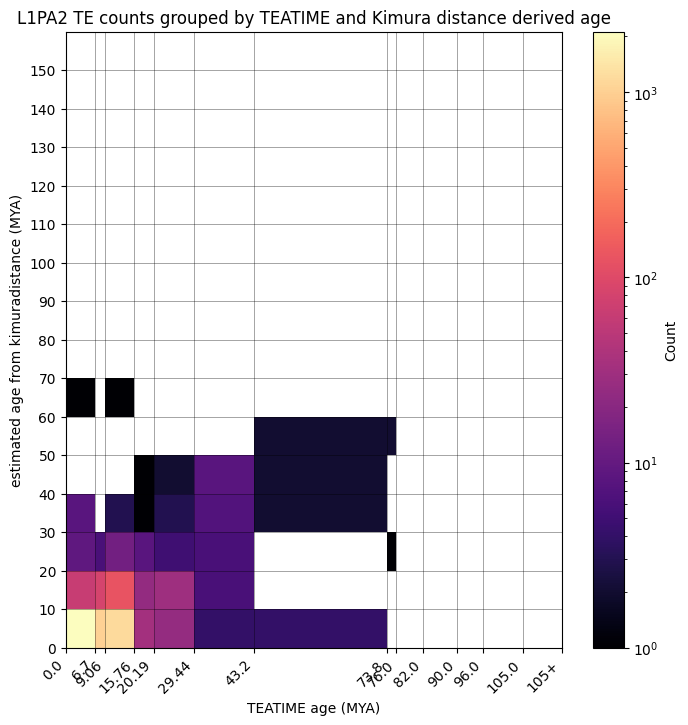

In [ ]:
#select specific class
subfam_of_interest = 'L1PA2'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

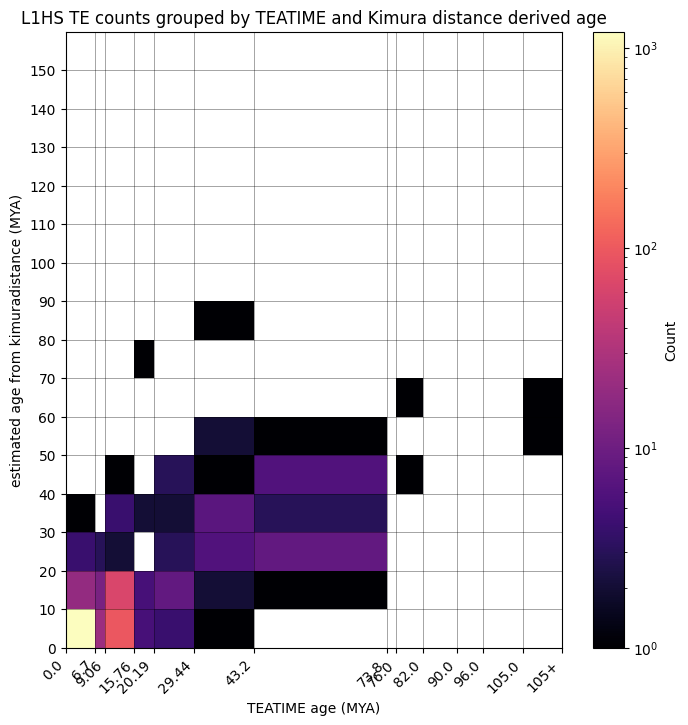

In [ ]:
#select specific class
subfam_of_interest = 'L1HS'
age_count_subfam=age_count_bysubfam[age_count_bysubfam['repName']==subfam_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())
y_labels = sorted(age_count_subfam["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_subfam["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_subfam["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_subfam.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{subfam_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

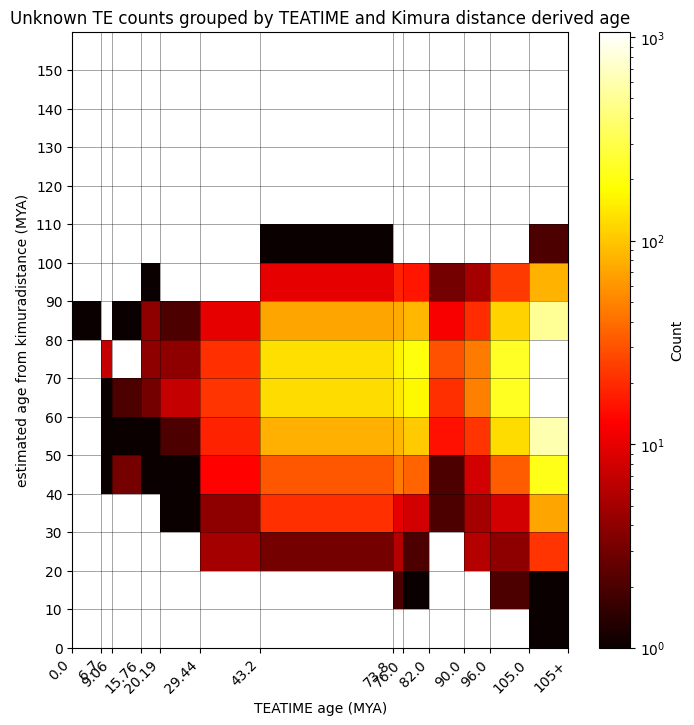

In [ ]:
#select specific class
class_of_interest = 'Unknown'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="hot", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

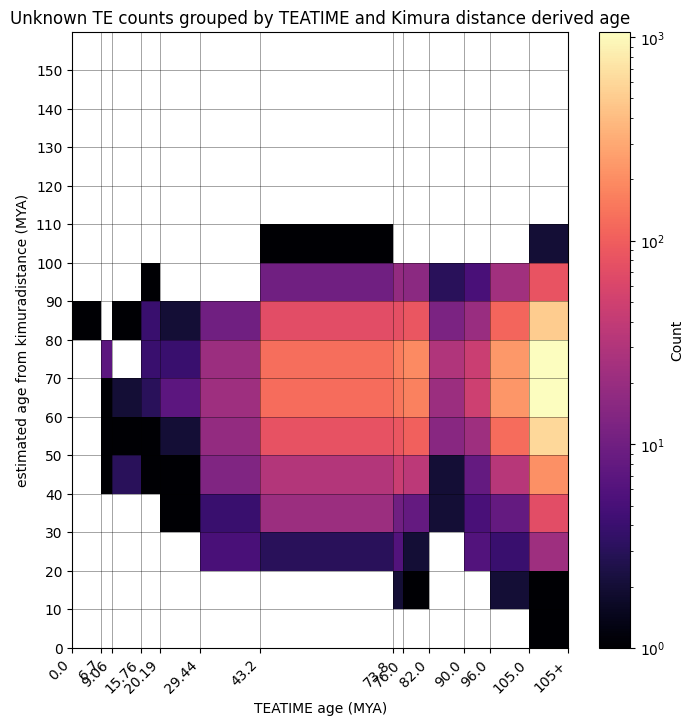

In [ ]:
#select specific class
class_of_interest = 'Unknown'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

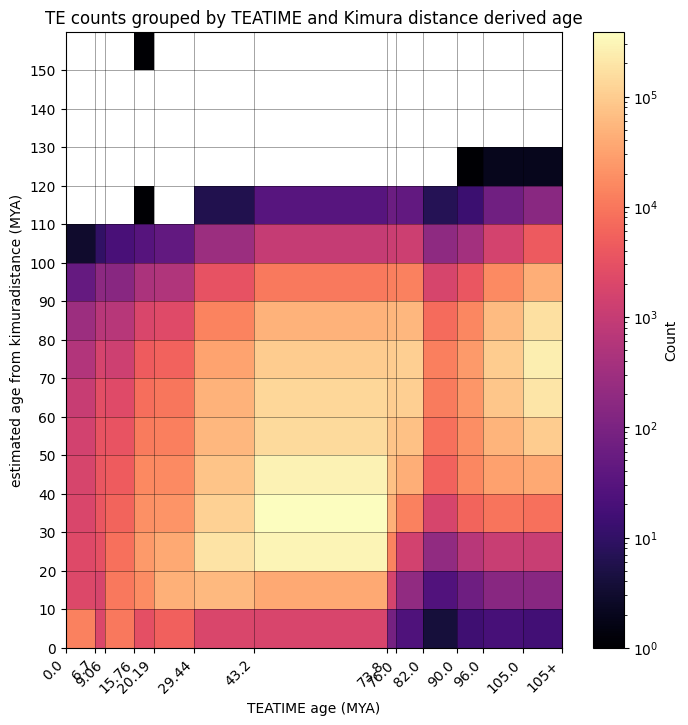

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_overall["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_overall["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_overall.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title("TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

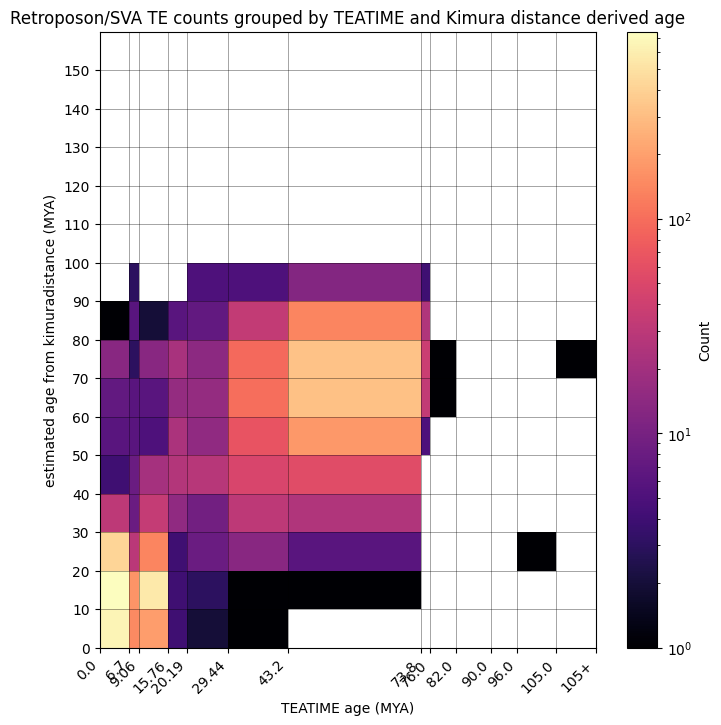

In [ ]:
#select specific class
class_of_interest = 'Retroposon/SVA'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

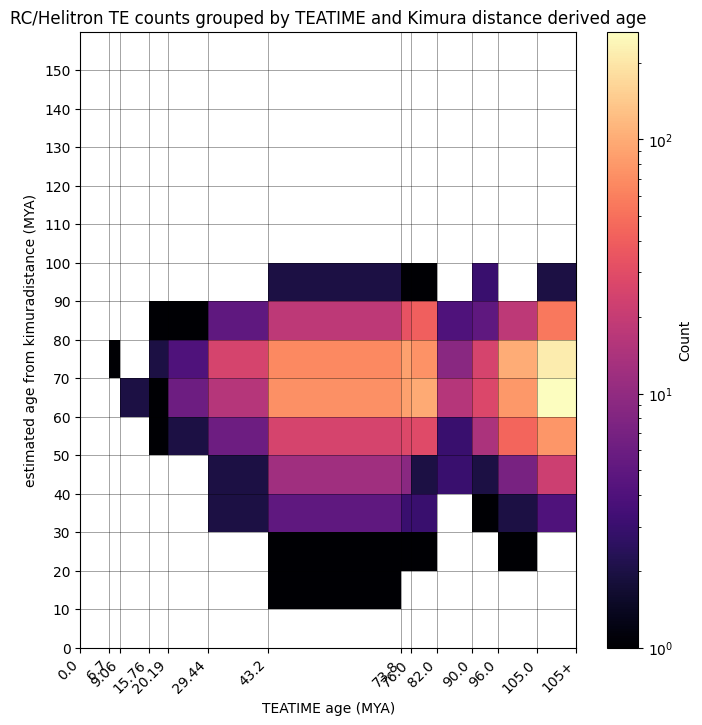

In [ ]:
#select specific class
class_of_interest = 'RC/Helitron'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

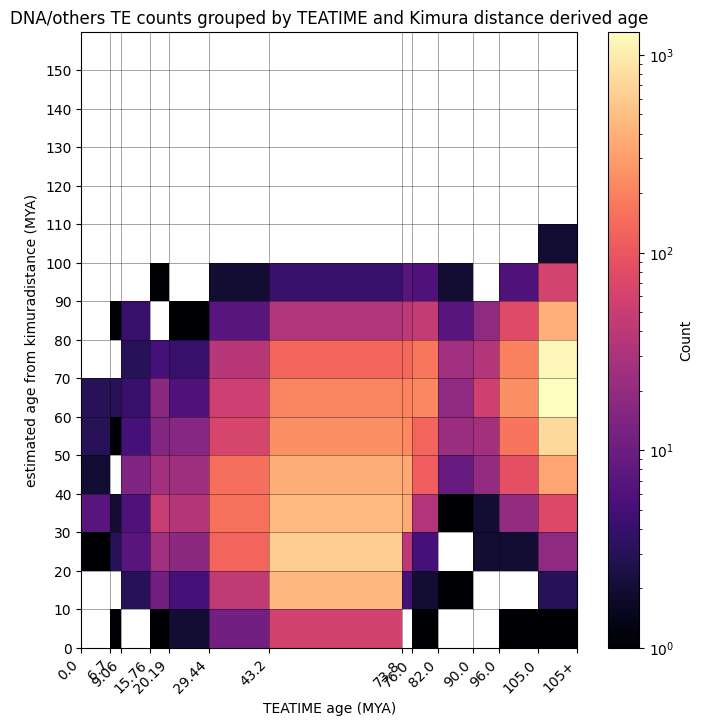

In [ ]:
#select specific class
class_of_interest = 'DNA/others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

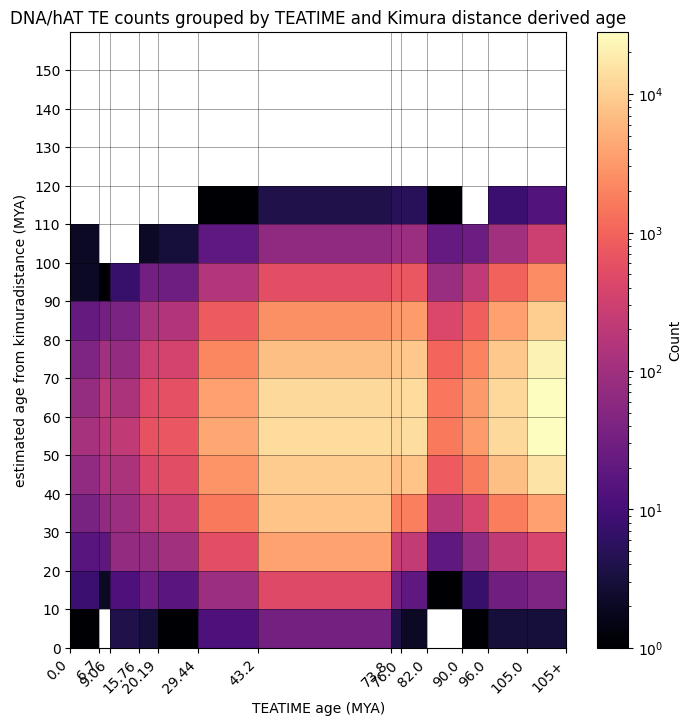

In [ ]:
#select specific class
class_of_interest = 'DNA/hAT'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

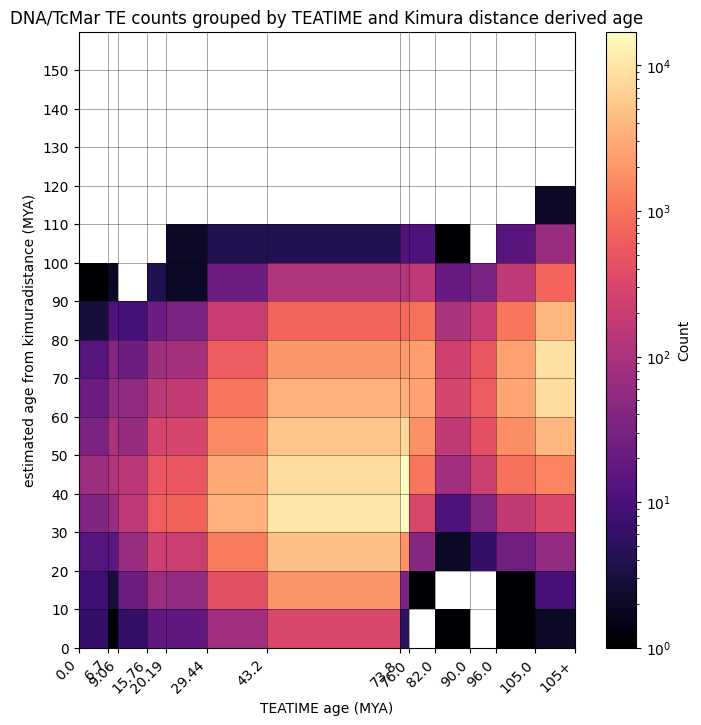

In [ ]:
#select specific class
class_of_interest = 'DNA/TcMar'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

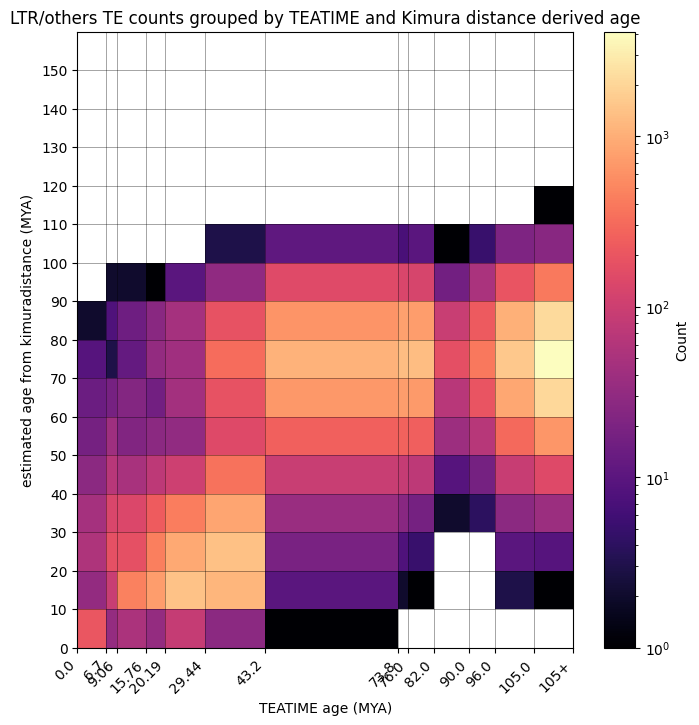

In [ ]:
#select specific class
class_of_interest = 'LTR/others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

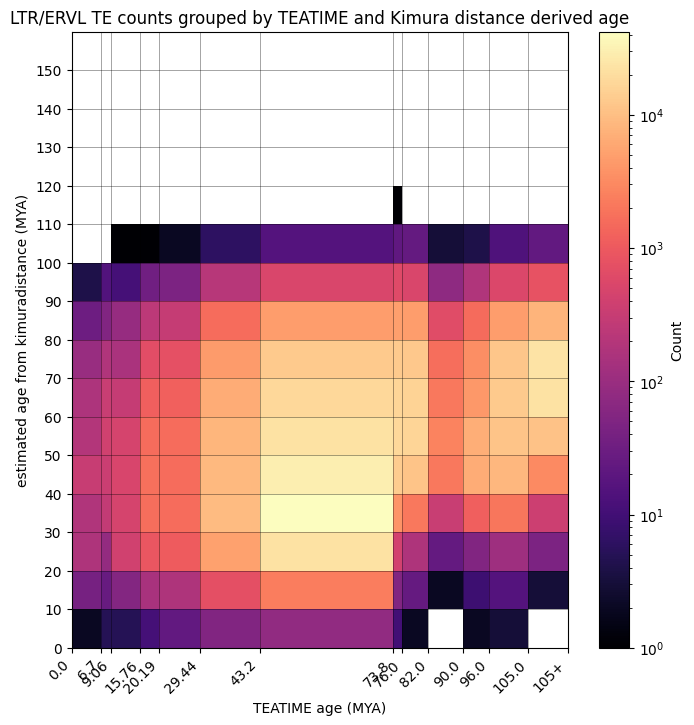

In [ ]:
#select specific class
class_of_interest = 'LTR/ERVL'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

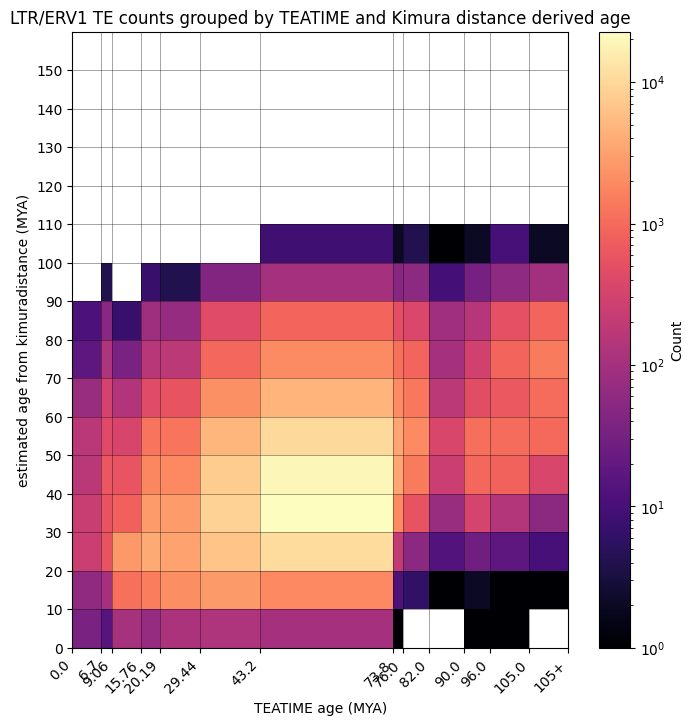

In [ ]:
#select specific class
class_of_interest = 'LTR/ERV1'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

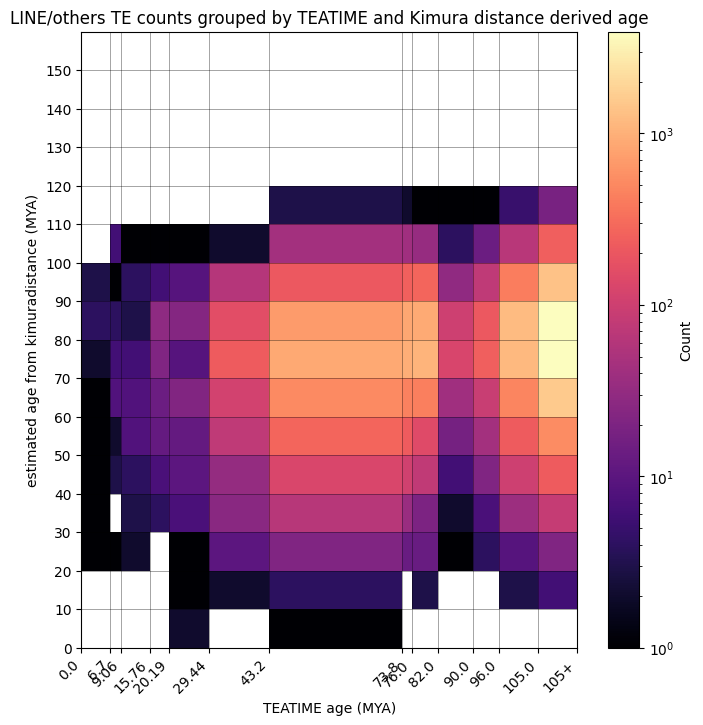

In [ ]:
#select specific class
class_of_interest = 'LINE/others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

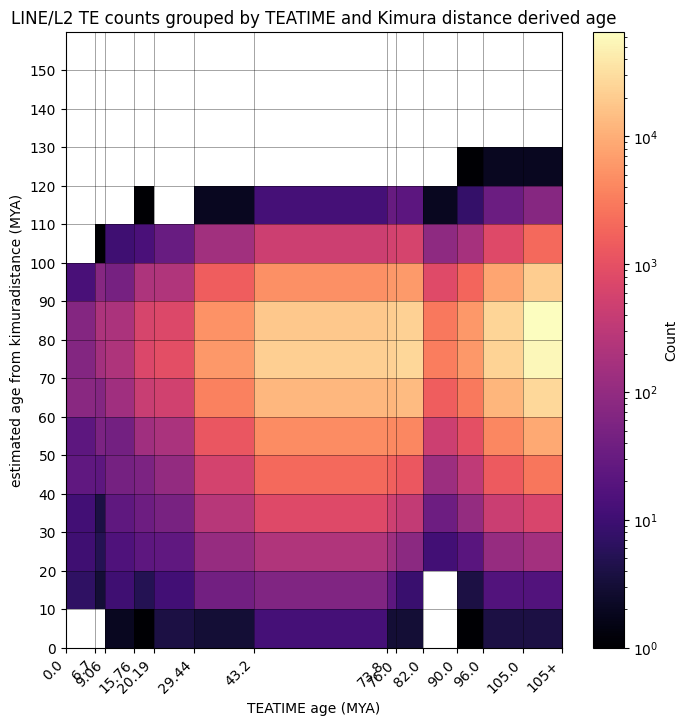

In [ ]:
#select specific class
class_of_interest = 'LINE/L2'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

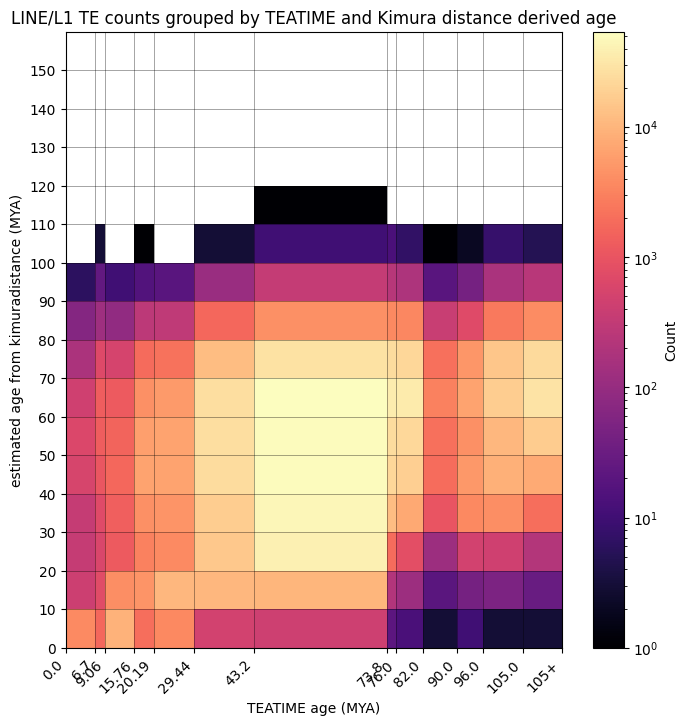

In [ ]:
#select specific class
class_of_interest = 'LINE/L1'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

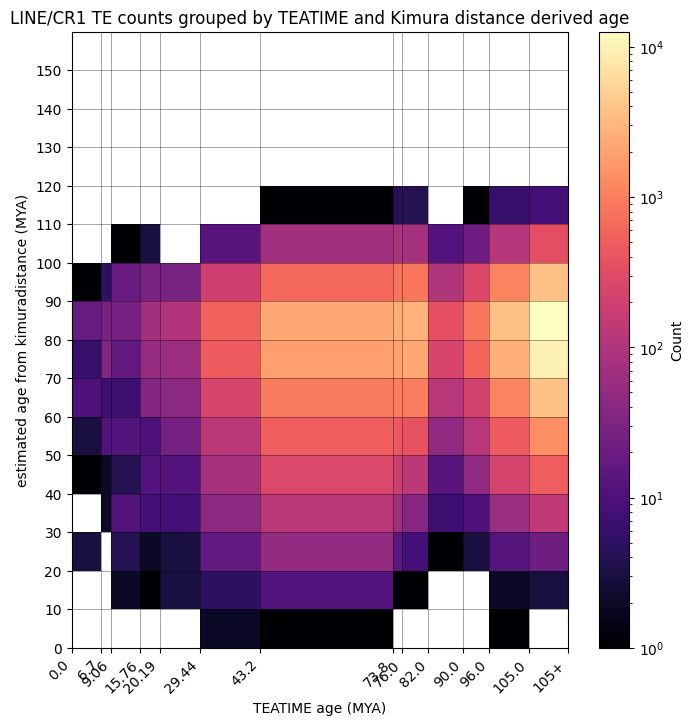

In [ ]:
#select specific class
class_of_interest = 'LINE/CR1'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

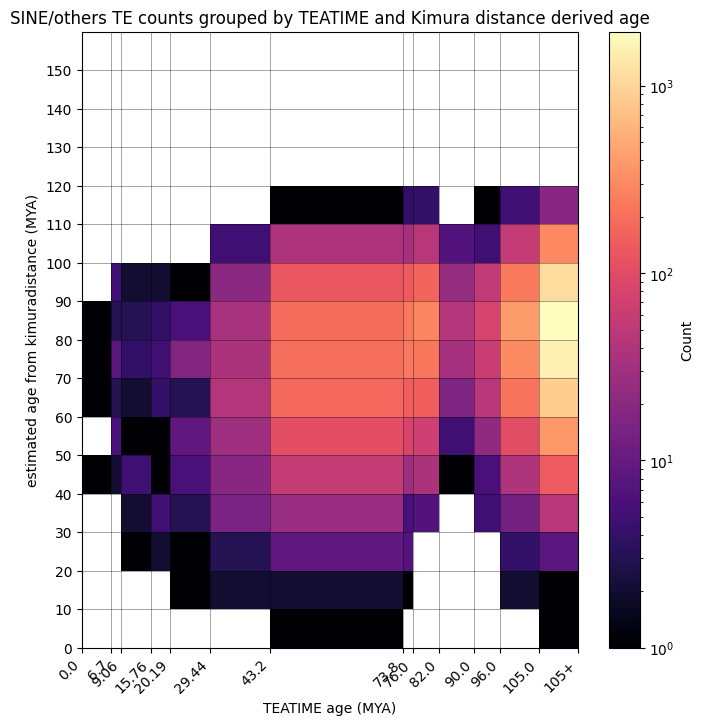

In [ ]:
#select specific class
class_of_interest = 'SINE/others'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

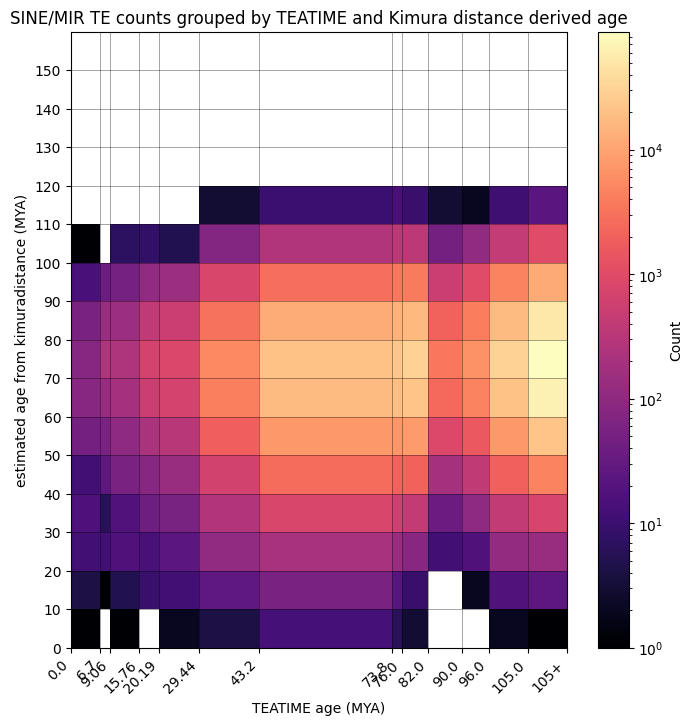

In [ ]:
#select specific class
class_of_interest = 'SINE/MIR'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()

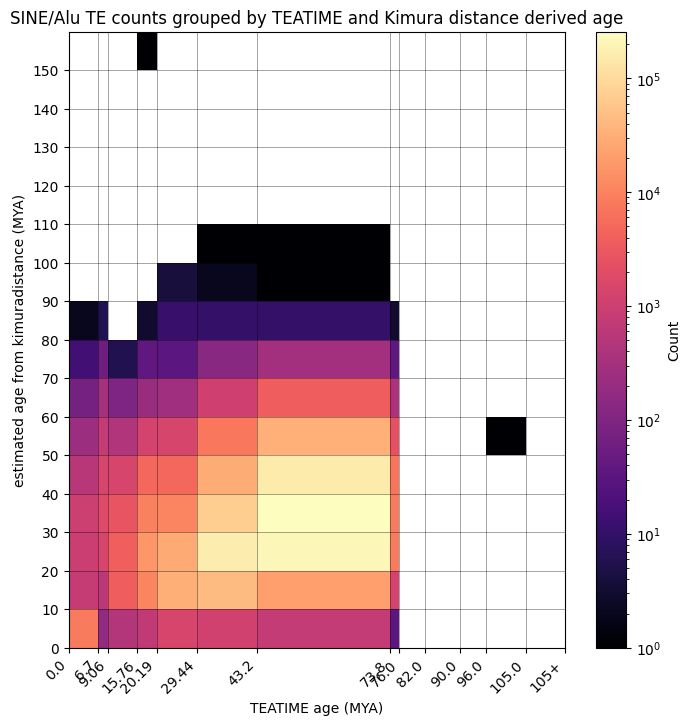

In [ ]:
#select specific class
class_of_interest = 'SINE/Alu'
age_count_class=age_count_byclass[age_count_byclass['custom_group']==class_of_interest]
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())
y_labels = sorted(age_count_class["mya_10binned"].unique())
# Create a 2D matrix filled with NaN (or zeros)
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)
# Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Get unique x (te_age) and y (mya_10binned) values
x_labels = sorted(age_count_class["te_age"].unique())  # Original x-labels
y_labels = sorted(age_count_class["mya_10binned"].unique())

# 🔹 Step 1: Define bin edges for x-axis based on real values
x_edges = np.array(x_labels + [x_labels[-1] + (x_labels[-1] - x_labels[-2])])  # Add extra edge for the last cell

# 🔹 Step 2: Define bin edges for y-axis (uniform in this case)
y_edges = np.array(y_labels + [y_labels[-1] + (y_labels[-1] - y_labels[-2])])

# 🔹 Step 3: Create 2D matrix filled with NaN
heatmap_array = np.full((len(y_labels), len(x_labels)), np.nan)

# 🔹 Step 4: Fill the matrix with counts
for _, row in age_count_class.iterrows():
    x_idx = x_labels.index(row["te_age"])
    y_idx = y_labels.index(row["mya_10binned"])
    heatmap_array[y_idx, x_idx] = row["count"]

# Define log-normalization for colors (ignoring zero values)
norm = mcolors.LogNorm(vmin=max(1, np.nanmin(heatmap_array)), vmax=np.nanmax(heatmap_array))

# 🔹 Step 5: Plot using `pcolormesh()` with custom bin edges
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.pcolormesh(x_edges, y_edges, heatmap_array, cmap="magma", norm=norm, shading="flat")

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Count")

# 🔹 Step 6: Set x-ticks at bin edges
ax.set_xticks(x_edges)
ax.set_xticklabels([str(x) for x in x_labels] + ["105+"], rotation=45, ha="right")

# Set y-ticks normally
ax.set_yticks(y_labels)
ax.set_yticklabels(y_labels)

ax.set_xlabel("TEATIME age (MYA)")
ax.set_ylabel("estimated age from kimuradistance (MYA)")
ax.set_title(f"{class_of_interest} TE counts grouped by TEATIME and Kimura distance derived age")

# 🔹 Step 7: Add gridlines to match custom bin sizes
ax.grid(True, which="both", color="black", linestyle="-", linewidth=0.5, alpha=0.5)

plt.show()